In [1]:
import pandas as pd
import numpy as np
from kmodes.kmodes import KModes
import pandas as pd
import time
import os
import multiprocessing as mp # for speeding up some process
import sys
sys.path.append('../py_model')
from utils import init_logging
import logging 
from scipy.cluster import hierarchy
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 10] # customizing


# Clustering using k-mode

In [ ]:
import pandas as pd

feature_scaling = True

#----------------------------
# loading original features
#----------------------------
original_raw_featurs = pd.read_hdf('../features/original_raw_featurs.h5','original_raw_featurs')
no_need_to_inpute = ['index']
original_raw_featurs.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
original_raw_featurs.replace([np.inf, -np.inf], np.nan, inplace = True)
print (original_raw_featurs.shape)

# # feature scaling with ignoring np.nan
# if feature_scaling == True:
#     for f in original_raw_featurs.columns.tolist():
#         mean = original_raw_featurs[f].mean()
#         std = original_raw_featurs[f].std()
#         original_raw_featurs[f] = (original_raw_featurs[f] - mean) / std

# preprocessing for clusting
original_raw_featurs.replace(np.nan, 0, inplace = True)

# check transpose
df_transposed = original_raw_featurs.T
print (df_transposed.shape)

# clustering

km = KModes(n_clusters=4, init='Cao', n_init=5, verbose=1)

clusters = km.fit_predict(df_transposed)

# output the clustering result
feature_clustering = pd.DataFrame({
    'features':df_transposed.index.tolist(),
    'cluster': km.labels_
})
# save the clustering result
feature_clustering.to_csv('../output/without_normalizing_feature_clustering.csv', index = False)

feature_clustering.cluster.value_counts()

In [21]:
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
feature_clustering.cluster.value_counts()

0    775
1     28
3      9
2      7
Name: cluster, dtype: int64

# KNN

In [4]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
same_cluster_features = feature_clustering[feature_clustering.cluster == 1].features.tolist()
for f_in_same_cluster in same_cluster_features:
    if f_in_same_cluster in set(df.columns.tolist()):
        print (f_in_same_cluster)
        print (df[f_in_same_cluster].count())

(356251, 281)
CODE_GENDER
356251
FLAG_DOCUMENT_3
356251
REGION_RATING_CLIENT
356251
REGION_RATING_CLIENT_W_CITY
356251
NAME_CONTRACT_TYPE_Cash loans
356251
NAME_EDUCATION_TYPE_Secondary / secondary special
356251
NAME_FAMILY_STATUS_Married
356251
NAME_HOUSING_TYPE_House / apartment
356251
NAME_INCOME_TYPE_Working
356251
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
338853
PREV_NAME_CONTRACT_STATUS_Approved_MEAN
338853
PREV_CODE_REJECT_REASON_XAP_MEAN
338853
PREV_NAME_PORTFOLIO_POS_MEAN
338853
POS_NAME_CONTRACT_STATUS_Active_MEAN
337248


In [5]:
base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
len(base_feature_worth_imputing_ls)

14

In [6]:
X_missing_df = df[base_feature_worth_imputing_ls]
# feature scaling before KNN
feature_scaling = True
if feature_scaling == True:
    for f in X_missing_df.columns.tolist():
        mean = X_missing_df[f].mean()
        std = X_missing_df[f].std()
        X_missing_df[f] = (X_missing_df[f] - mean) / std
        
print ('X_missing_df', X_missing_df.shape)
small_df_ls = []
num_split = 20
previous_step = None
for i, step in enumerate(np.arange(0, X_missing_df.shape[0], step = int(X_missing_df.shape[0] / num_split))):
    # for memory problem, we cannot feed all the data points into algorithm, which depends on row and n_features
    if i == 0:
        pass
    elif i == 1:
        small_df_ls.append(X_missing_df[0: step])
        previous_step = step
    elif i == (num_split):
        small_df_ls.append(X_missing_df[previous_step: ])
        break
    else:
        small_df_ls.append(X_missing_df[previous_step: step])
        previous_step = step
pd.concat(small_df_ls, axis = 0).shape

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


X_missing_df (356251, 14)


(356251, 14)

In [8]:
X_filled1 = pd.concat(small_df_filled_ls, axis = 0)
'X_filled1 : {}'.format(X_filled1.shape)

'X_filled1 : (356251, 14)'

In [16]:
#----------------------------
# reload base_features for filling
#----------------------------
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
for f_in_same_cluster in X_filled1.columns.tolist():
    if f_in_same_cluster in set(df.columns.tolist()):
        logging.info('featurs : {}'.format(f_in_same_cluster))
        df[f_in_same_cluster] = X_filled1[f_in_same_cluster].tolist()

if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)
    
df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')

In [17]:
df.shape

(356251, 280)

In [18]:
#-------------------
# save
#-------------------
output_path = '../features/filled_by_knn'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_knn_65_cluster1.h5'), 'normalized_knn_65_cluster1')



In [22]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
same_cluster_features = feature_clustering[feature_clustering.cluster == 2].features.tolist()
for f_in_same_cluster in same_cluster_features:
    if f_in_same_cluster in set(df.columns.tolist()):
        print (f_in_same_cluster)
        print (df[f_in_same_cluster].count())
base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
print ('num_base_feature_worth_imputing_set' , len(base_feature_worth_imputing_ls))
#------

#-----
X_missing_df = df[base_feature_worth_imputing_ls]
# feature scaling before KNN
feature_scaling = True
if feature_scaling == True:
    for f in X_missing_df.columns.tolist():
        mean = X_missing_df[f].mean()
        std = X_missing_df[f].std()
        X_missing_df[f] = (X_missing_df[f] - mean) / std
        
print ('X_missing_df', X_missing_df.shape)
small_df_ls = []
num_split = 20
previous_step = None
for i, step in enumerate(np.arange(0, X_missing_df.shape[0], step = int(X_missing_df.shape[0] / num_split))):
    # for memory problem, we cannot feed all the data points into algorithm, which depends on row and n_features
    if i == 0:
        pass
    elif i == 1:
        small_df_ls.append(X_missing_df[0: step])
        previous_step = step
    elif i == (num_split):
        small_df_ls.append(X_missing_df[previous_step: ])
        break
    else:
        small_df_ls.append(X_missing_df[previous_step: step])
        previous_step = step
        
print ('splitting is okay? {}'.format(pd.concat(small_df_ls, axis = 0).shape))

def multi(small_df):
    k = 65
    X_missing = small_df.copy()
    print ('input of KNN imputing : {}'.format(X_missing.shape))
    # core algorithm: input should be array
    X_filled = KNN(k = k).complete(X_missing.values)
    return pd.DataFrame(X_filled, columns = X_missing.columns)

mp_pool = mp.Pool(len(small_df_ls)) 
small_df_filled_ls = mp_pool.map(multi, small_df_ls)
X_filled1 = pd.concat(small_df_filled_ls, axis = 0)
print ('X_filled1 : {}'.format(X_filled1.shape))

#----------------------------
# reload base_features for filling
#----------------------------
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
for f_in_same_cluster in X_filled1.columns.tolist():
    if f_in_same_cluster in set(df.columns.tolist()):
        logging.info('featurs : {}'.format(f_in_same_cluster))
        df[f_in_same_cluster] = X_filled1[f_in_same_cluster].tolist()

if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)
    
df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')
print ('final', df.shape)
#-------------------
# save
#-------------------
output_path = '../features/filled_by_knn'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_knn_65_cluster2.h5'), 'normalized_knn_65_cluster2')



(356251, 281)
PREV_NAME_PAYMENT_TYPE_XNA_MEAN
338853
PREV_NAME_TYPE_SUITE_nan_MEAN
338853
PREV_NAME_CLIENT_TYPE_New_MEAN
338853
PREV_NAME_YIELD_GROUP_XNA_MEAN
338853
num_base_feature_worth_imputing_set 4
X_missing_df (356251, 4)
splitting is okay? (356251, 4)


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17812, 4)
input of KNN imputing : (17823, 4)
Imputing row 1/17812 with 0 missing, elapsed time: 60.731
Imputing row 101/17812 with 4 missing, elapsed time: 60.734
Imputing row 201/17812 with 0 missing, elapsed time: 60.737
Imputing row 301/17812 with 0 missing, elapsed time: 60.739
Imputing row 401/17812 with 0 missing, elapsed time: 60.741
Im

Imputing row 12301/17812 with 0 missing, elapsed time: 60.941
Imputing row 12401/17812 with 0 missing, elapsed time: 60.942
Imputing row 12501/17812 with 0 missing, elapsed time: 60.943
Imputing row 12601/17812 with 0 missing, elapsed time: 60.944
Imputing row 12701/17812 with 0 missing, elapsed time: 60.945
Imputing row 12801/17812 with 0 missing, elapsed time: 60.946
Imputing row 12901/17812 with 0 missing, elapsed time: 60.947
Imputing row 13001/17812 with 0 missing, elapsed time: 60.948
Imputing row 13101/17812 with 0 missing, elapsed time: 60.949
Imputing row 13201/17812 with 0 missing, elapsed time: 60.950
Imputing row 13301/17812 with 0 missing, elapsed time: 60.952
Imputing row 13401/17812 with 4 missing, elapsed time: 60.953
Imputing row 13501/17812 with 0 missing, elapsed time: 60.954
Imputing row 13601/17812 with 0 missing, elapsed time: 60.955
Imputing row 13701/17812 with 0 missing, elapsed time: 60.956
Imputing row 13801/17812 with 0 missing, elapsed time: 60.958
Imputing

Imputing row 7701/17812 with 0 missing, elapsed time: 61.725
Imputing row 7801/17812 with 0 missing, elapsed time: 61.727
Imputing row 7901/17812 with 0 missing, elapsed time: 61.728
Imputing row 8001/17812 with 0 missing, elapsed time: 61.729
Imputing row 8101/17812 with 0 missing, elapsed time: 61.730
Imputing row 8201/17812 with 0 missing, elapsed time: 61.731
Imputing row 8301/17812 with 0 missing, elapsed time: 61.732
Imputing row 8401/17812 with 0 missing, elapsed time: 61.734
Imputing row 8501/17812 with 0 missing, elapsed time: 61.735
Imputing row 8601/17812 with 0 missing, elapsed time: 61.737
Imputing row 8701/17812 with 0 missing, elapsed time: 61.738
Imputing row 8801/17812 with 0 missing, elapsed time: 61.739
Imputing row 8901/17812 with 0 missing, elapsed time: 61.741
Imputing row 9001/17812 with 0 missing, elapsed time: 61.745
Imputing row 9101/17812 with 0 missing, elapsed time: 61.747
Imputing row 9201/17812 with 0 missing, elapsed time: 61.750
Imputing row 9301/17812 

Imputing row 3001/17812 with 4 missing, elapsed time: 62.266
Imputing row 3101/17812 with 0 missing, elapsed time: 62.270
Imputing row 3201/17812 with 4 missing, elapsed time: 62.272
Imputing row 3301/17812 with 0 missing, elapsed time: 62.275
Imputing row 3401/17812 with 0 missing, elapsed time: 62.278
Imputing row 3501/17812 with 0 missing, elapsed time: 62.281
Imputing row 3601/17812 with 0 missing, elapsed time: 62.283
Imputing row 3701/17812 with 0 missing, elapsed time: 62.286
Imputing row 3801/17812 with 0 missing, elapsed time: 62.289
Imputing row 3901/17812 with 0 missing, elapsed time: 62.292
Imputing row 4001/17812 with 0 missing, elapsed time: 62.294
Imputing row 4101/17812 with 0 missing, elapsed time: 62.297
Imputing row 4201/17812 with 0 missing, elapsed time: 62.299
Imputing row 4301/17812 with 0 missing, elapsed time: 62.301
Imputing row 4401/17812 with 0 missing, elapsed time: 62.304
Imputing row 4501/17812 with 0 missing, elapsed time: 62.306
Imputing row 4601/17812 

Imputing row 16401/17812 with 0 missing, elapsed time: 62.626
Imputing row 16501/17812 with 0 missing, elapsed time: 62.630
Imputing row 16601/17812 with 0 missing, elapsed time: 62.634
Imputing row 16701/17812 with 0 missing, elapsed time: 62.637
Imputing row 16801/17812 with 0 missing, elapsed time: 62.640
Imputing row 16901/17812 with 0 missing, elapsed time: 62.642
Imputing row 17001/17812 with 4 missing, elapsed time: 62.644
Imputing row 17101/17812 with 0 missing, elapsed time: 62.647
Imputing row 17201/17812 with 0 missing, elapsed time: 62.649
Imputing row 17301/17812 with 0 missing, elapsed time: 62.652
Imputing row 17401/17812 with 0 missing, elapsed time: 62.654
Imputing row 17501/17812 with 0 missing, elapsed time: 62.657
Imputing row 17601/17812 with 0 missing, elapsed time: 62.659
Imputing row 17701/17812 with 0 missing, elapsed time: 62.663
Imputing row 17801/17812 with 0 missing, elapsed time: 62.665
[KNN] Warning: 3948/71248 still missing after imputation, replacing wi

Imputing row 11801/17812 with 0 missing, elapsed time: 63.419
Imputing row 11901/17812 with 0 missing, elapsed time: 63.422
Imputing row 12001/17812 with 0 missing, elapsed time: 63.424
Imputing row 12101/17812 with 0 missing, elapsed time: 63.427
Imputing row 12201/17812 with 0 missing, elapsed time: 63.429
Imputing row 12301/17812 with 0 missing, elapsed time: 63.431
Imputing row 12401/17812 with 0 missing, elapsed time: 63.433
Imputing row 12501/17812 with 0 missing, elapsed time: 63.435
Imputing row 12601/17812 with 0 missing, elapsed time: 63.437
Imputing row 12701/17812 with 0 missing, elapsed time: 63.439
Imputing row 12801/17812 with 0 missing, elapsed time: 63.441
Imputing row 12901/17812 with 0 missing, elapsed time: 63.443
Imputing row 13001/17812 with 0 missing, elapsed time: 63.444
Imputing row 13101/17812 with 0 missing, elapsed time: 63.446
Imputing row 13201/17812 with 0 missing, elapsed time: 63.448
Imputing row 13301/17812 with 0 missing, elapsed time: 63.450
Imputing

Imputing row 1201/17812 with 0 missing, elapsed time: 63.724
Imputing row 1301/17812 with 4 missing, elapsed time: 63.726
Imputing row 1401/17812 with 0 missing, elapsed time: 63.727
Imputing row 6001/17812 with 0 missing, elapsed time: 63.745
Imputing row 1501/17812 with 0 missing, elapsed time: 63.728
Imputing row 1601/17812 with 0 missing, elapsed time: 63.729
Imputing row 6101/17812 with 0 missing, elapsed time: 63.748
Imputing row 1701/17812 with 0 missing, elapsed time: 63.731
Imputing row 1801/17812 with 0 missing, elapsed time: 63.732
Imputing row 6201/17812 with 0 missing, elapsed time: 63.751
Imputing row 1901/17812 with 0 missing, elapsed time: 63.733
Imputing row 2001/17812 with 0 missing, elapsed time: 63.734
Imputing row 2101/17812 with 0 missing, elapsed time: 63.735
Imputing row 6301/17812 with 0 missing, elapsed time: 63.753
Imputing row 2201/17812 with 0 missing, elapsed time: 63.736
Imputing row 2301/17812 with 0 missing, elapsed time: 63.737
Imputing row 6401/17812 

Imputing row 10801/17812 with 0 missing, elapsed time: 63.864
Imputing row 9901/17812 with 0 missing, elapsed time: 63.846
Imputing row 10001/17812 with 0 missing, elapsed time: 63.847
Imputing row 10901/17812 with 0 missing, elapsed time: 63.866
Imputing row 10101/17812 with 0 missing, elapsed time: 63.849
Imputing row 10201/17812 with 0 missing, elapsed time: 63.850
Imputing row 11001/17812 with 0 missing, elapsed time: 63.869
Imputing row 10301/17812 with 0 missing, elapsed time: 63.851
Imputing row 10401/17812 with 0 missing, elapsed time: 63.852
Imputing row 11101/17812 with 0 missing, elapsed time: 63.871
Imputing row 10501/17812 with 0 missing, elapsed time: 63.853
Imputing row 10601/17812 with 0 missing, elapsed time: 63.854
Imputing row 11201/17812 with 0 missing, elapsed time: 63.873
Imputing row 10701/17812 with 0 missing, elapsed time: 63.855
Imputing row 10801/17812 with 0 missing, elapsed time: 63.856
Imputing row 11301/17812 with 0 missing, elapsed time: 63.875
Imputing 

Imputing row 16101/17812 with 0 missing, elapsed time: 64.012
Imputing row 16201/17812 with 0 missing, elapsed time: 64.015
Imputing row 16301/17812 with 0 missing, elapsed time: 64.019
Imputing row 16401/17812 with 0 missing, elapsed time: 64.021
Imputing row 16501/17812 with 0 missing, elapsed time: 64.024
Imputing row 16601/17812 with 0 missing, elapsed time: 64.028
Imputing row 1/17812 with 0 missing, elapsed time: 63.995
Imputing row 101/17812 with 0 missing, elapsed time: 63.998
Imputing row 16701/17812 with 0 missing, elapsed time: 64.032
Imputing row 201/17812 with 4 missing, elapsed time: 63.999
[KNN] Warning: 3928/71248 still missing after imputation, replacing with 0
Imputing row 16801/17812 with 0 missing, elapsed time: 64.034
Imputing row 301/17812 with 0 missing, elapsed time: 64.002
Imputing row 16901/17812 with 0 missing, elapsed time: 64.036
Imputing row 401/17812 with 0 missing, elapsed time: 64.003
Imputing row 17001/17812 with 0 missing, elapsed time: 64.037
Imputin

Imputing row 11401/17812 with 0 missing, elapsed time: 64.203
Imputing row 11501/17812 with 0 missing, elapsed time: 64.205
Imputing row 11601/17812 with 0 missing, elapsed time: 64.206
Imputing row 11701/17812 with 0 missing, elapsed time: 64.208
Imputing row 11801/17812 with 0 missing, elapsed time: 64.209
Imputing row 11901/17812 with 0 missing, elapsed time: 64.211
Imputing row 12001/17812 with 0 missing, elapsed time: 64.213
Imputing row 12101/17812 with 0 missing, elapsed time: 64.215
Imputing row 12201/17812 with 0 missing, elapsed time: 64.216
Imputing row 12301/17812 with 0 missing, elapsed time: 64.218
Imputing row 12401/17812 with 0 missing, elapsed time: 64.219
Imputing row 12501/17812 with 0 missing, elapsed time: 64.221
Imputing row 12601/17812 with 0 missing, elapsed time: 64.223
Imputing row 12701/17812 with 0 missing, elapsed time: 64.224
Imputing row 12801/17812 with 0 missing, elapsed time: 64.226
Imputing row 12901/17812 with 0 missing, elapsed time: 64.227
Imputing

Imputing row 6801/17812 with 0 missing, elapsed time: 64.828
Imputing row 6901/17812 with 0 missing, elapsed time: 64.830
Imputing row 7001/17812 with 0 missing, elapsed time: 64.831
Imputing row 7101/17812 with 0 missing, elapsed time: 64.833
Imputing row 7201/17812 with 4 missing, elapsed time: 64.834
Imputing row 7301/17812 with 0 missing, elapsed time: 64.836
Imputing row 7401/17812 with 0 missing, elapsed time: 64.837
Imputing row 7501/17812 with 0 missing, elapsed time: 64.838
Imputing row 7601/17812 with 0 missing, elapsed time: 64.839
Imputing row 7701/17812 with 0 missing, elapsed time: 64.840
Imputing row 7801/17812 with 0 missing, elapsed time: 64.842
Imputing row 7901/17812 with 0 missing, elapsed time: 64.843
Imputing row 8001/17812 with 0 missing, elapsed time: 64.845
Imputing row 8101/17812 with 0 missing, elapsed time: 64.846
Imputing row 8201/17812 with 0 missing, elapsed time: 64.848
Imputing row 8301/17812 with 0 missing, elapsed time: 64.849
Imputing row 8401/17812 

Imputing row 2101/17823 with 0 missing, elapsed time: 66.833
Imputing row 2201/17823 with 0 missing, elapsed time: 66.834
Imputing row 2301/17823 with 0 missing, elapsed time: 66.835
Imputing row 2401/17823 with 0 missing, elapsed time: 66.836
Imputing row 2501/17823 with 0 missing, elapsed time: 66.838
Imputing row 2601/17823 with 0 missing, elapsed time: 66.839
Imputing row 2701/17823 with 0 missing, elapsed time: 66.840
Imputing row 2801/17823 with 0 missing, elapsed time: 66.842
Imputing row 2901/17823 with 0 missing, elapsed time: 66.843
Imputing row 3001/17823 with 0 missing, elapsed time: 66.844
Imputing row 3101/17823 with 0 missing, elapsed time: 66.845
Imputing row 3201/17823 with 0 missing, elapsed time: 66.847
Imputing row 3301/17823 with 0 missing, elapsed time: 66.848
Imputing row 3401/17823 with 0 missing, elapsed time: 66.849
Imputing row 3501/17823 with 0 missing, elapsed time: 66.850
Imputing row 3601/17823 with 0 missing, elapsed time: 66.851
Imputing row 3701/17823 

Imputing row 15501/17823 with 0 missing, elapsed time: 66.984
Imputing row 15601/17823 with 0 missing, elapsed time: 66.985
Imputing row 15701/17823 with 0 missing, elapsed time: 66.986
Imputing row 15801/17823 with 0 missing, elapsed time: 66.987
Imputing row 15901/17823 with 0 missing, elapsed time: 66.987
Imputing row 16001/17823 with 0 missing, elapsed time: 66.988
Imputing row 16101/17823 with 0 missing, elapsed time: 66.989
Imputing row 16201/17823 with 0 missing, elapsed time: 66.990
Imputing row 16301/17823 with 0 missing, elapsed time: 66.991
Imputing row 16401/17823 with 0 missing, elapsed time: 66.992
Imputing row 16501/17823 with 0 missing, elapsed time: 66.993
Imputing row 16601/17823 with 4 missing, elapsed time: 66.994
Imputing row 16701/17823 with 0 missing, elapsed time: 66.995
Imputing row 16801/17823 with 0 missing, elapsed time: 66.996
Imputing row 1/17812 with 0 missing, elapsed time: 67.180
Imputing row 16901/17823 with 0 missing, elapsed time: 66.997
Imputing row

Imputing row 10901/17812 with 0 missing, elapsed time: 67.360
Imputing row 11001/17812 with 0 missing, elapsed time: 67.362
Imputing row 11101/17812 with 0 missing, elapsed time: 67.363
Imputing row 11201/17812 with 0 missing, elapsed time: 67.364
Imputing row 11301/17812 with 0 missing, elapsed time: 67.366
Imputing row 11401/17812 with 0 missing, elapsed time: 67.367
Imputing row 11501/17812 with 0 missing, elapsed time: 67.369
Imputing row 11601/17812 with 0 missing, elapsed time: 67.370
Imputing row 11701/17812 with 0 missing, elapsed time: 67.371
Imputing row 11801/17812 with 0 missing, elapsed time: 67.373
Imputing row 11901/17812 with 0 missing, elapsed time: 67.374
Imputing row 12001/17812 with 0 missing, elapsed time: 67.376
Imputing row 12101/17812 with 0 missing, elapsed time: 67.377
Imputing row 12201/17812 with 0 missing, elapsed time: 67.379
Imputing row 12301/17812 with 0 missing, elapsed time: 67.380
Imputing row 12401/17812 with 0 missing, elapsed time: 67.382
Imputing

Imputing row 6301/17812 with 0 missing, elapsed time: 67.790
Imputing row 6401/17812 with 0 missing, elapsed time: 67.791
Imputing row 6501/17812 with 0 missing, elapsed time: 67.792
Imputing row 6601/17812 with 0 missing, elapsed time: 67.793
Imputing row 6701/17812 with 0 missing, elapsed time: 67.794
Imputing row 6801/17812 with 0 missing, elapsed time: 67.795
Imputing row 6901/17812 with 0 missing, elapsed time: 67.796
Imputing row 7001/17812 with 0 missing, elapsed time: 67.797
Imputing row 7101/17812 with 0 missing, elapsed time: 67.798
Imputing row 7201/17812 with 0 missing, elapsed time: 67.799
Imputing row 7301/17812 with 0 missing, elapsed time: 67.800
Imputing row 7401/17812 with 4 missing, elapsed time: 67.801
Imputing row 7501/17812 with 0 missing, elapsed time: 67.802
Imputing row 7601/17812 with 0 missing, elapsed time: 67.803
Imputing row 7701/17812 with 0 missing, elapsed time: 67.804
Imputing row 7801/17812 with 0 missing, elapsed time: 67.805
Imputing row 7901/17812 

Imputing row 1601/17812 with 0 missing, elapsed time: 67.791
Imputing row 1701/17812 with 0 missing, elapsed time: 67.793
Imputing row 1801/17812 with 0 missing, elapsed time: 67.794
Imputing row 1901/17812 with 4 missing, elapsed time: 67.795
Imputing row 2001/17812 with 0 missing, elapsed time: 67.797
Imputing row 2101/17812 with 0 missing, elapsed time: 67.798
Imputing row 2201/17812 with 0 missing, elapsed time: 67.799
Imputing row 2301/17812 with 0 missing, elapsed time: 67.800
Imputing row 2401/17812 with 0 missing, elapsed time: 67.802
Imputing row 2501/17812 with 0 missing, elapsed time: 67.803
Imputing row 2601/17812 with 0 missing, elapsed time: 67.804
Imputing row 2701/17812 with 0 missing, elapsed time: 67.805
Imputing row 2801/17812 with 0 missing, elapsed time: 67.807
Imputing row 2901/17812 with 0 missing, elapsed time: 67.808
Imputing row 3001/17812 with 0 missing, elapsed time: 67.809
Imputing row 3101/17812 with 0 missing, elapsed time: 67.810
Imputing row 3201/17812 

Imputing row 15001/17812 with 0 missing, elapsed time: 67.973
Imputing row 15101/17812 with 0 missing, elapsed time: 67.974
Imputing row 15201/17812 with 0 missing, elapsed time: 67.975
Imputing row 15301/17812 with 0 missing, elapsed time: 67.976
Imputing row 15401/17812 with 0 missing, elapsed time: 67.977
Imputing row 15501/17812 with 0 missing, elapsed time: 67.979
Imputing row 15601/17812 with 0 missing, elapsed time: 67.980
Imputing row 15701/17812 with 0 missing, elapsed time: 67.981
Imputing row 15801/17812 with 0 missing, elapsed time: 67.982
Imputing row 15901/17812 with 0 missing, elapsed time: 67.984
Imputing row 16001/17812 with 0 missing, elapsed time: 67.985
Imputing row 16101/17812 with 0 missing, elapsed time: 67.986
Imputing row 16201/17812 with 0 missing, elapsed time: 67.988
Imputing row 16301/17812 with 0 missing, elapsed time: 67.989
Imputing row 16401/17812 with 0 missing, elapsed time: 67.990
Imputing row 16501/17812 with 0 missing, elapsed time: 67.992
Imputing

Imputing row 10401/17812 with 0 missing, elapsed time: 68.504
Imputing row 10501/17812 with 0 missing, elapsed time: 68.505
Imputing row 10601/17812 with 0 missing, elapsed time: 68.507
Imputing row 10701/17812 with 0 missing, elapsed time: 68.508
Imputing row 10801/17812 with 0 missing, elapsed time: 68.510
Imputing row 10901/17812 with 0 missing, elapsed time: 68.511
Imputing row 11001/17812 with 0 missing, elapsed time: 68.513
Imputing row 11101/17812 with 0 missing, elapsed time: 68.514
Imputing row 11201/17812 with 0 missing, elapsed time: 68.515
Imputing row 11301/17812 with 0 missing, elapsed time: 68.517
Imputing row 11401/17812 with 0 missing, elapsed time: 68.519
Imputing row 11501/17812 with 0 missing, elapsed time: 68.520
Imputing row 11601/17812 with 0 missing, elapsed time: 68.522
Imputing row 11701/17812 with 0 missing, elapsed time: 68.523
Imputing row 11801/17812 with 0 missing, elapsed time: 68.524
Imputing row 11901/17812 with 0 missing, elapsed time: 68.526
Imputing

Imputing row 5801/17812 with 0 missing, elapsed time: 69.843
Imputing row 5901/17812 with 0 missing, elapsed time: 69.845
Imputing row 6001/17812 with 0 missing, elapsed time: 69.846
Imputing row 6101/17812 with 0 missing, elapsed time: 69.848
Imputing row 6201/17812 with 0 missing, elapsed time: 69.850
Imputing row 6301/17812 with 0 missing, elapsed time: 69.852
Imputing row 6401/17812 with 0 missing, elapsed time: 69.853
Imputing row 6501/17812 with 0 missing, elapsed time: 69.855
Imputing row 6601/17812 with 0 missing, elapsed time: 69.857
Imputing row 6701/17812 with 0 missing, elapsed time: 69.858
Imputing row 6801/17812 with 0 missing, elapsed time: 69.860
Imputing row 6901/17812 with 0 missing, elapsed time: 69.862
Imputing row 7001/17812 with 0 missing, elapsed time: 69.864
Imputing row 7101/17812 with 0 missing, elapsed time: 69.865
Imputing row 7201/17812 with 0 missing, elapsed time: 69.867
Imputing row 7301/17812 with 0 missing, elapsed time: 69.868
Imputing row 7401/17812 

Imputing row 1101/17812 with 0 missing, elapsed time: 71.520
Imputing row 1201/17812 with 0 missing, elapsed time: 71.523
Imputing row 1301/17812 with 0 missing, elapsed time: 71.525
Imputing row 1401/17812 with 0 missing, elapsed time: 71.527
Imputing row 1501/17812 with 0 missing, elapsed time: 71.528
Imputing row 1601/17812 with 0 missing, elapsed time: 71.530
Imputing row 1701/17812 with 0 missing, elapsed time: 71.532
Imputing row 1801/17812 with 0 missing, elapsed time: 71.533
Imputing row 1901/17812 with 0 missing, elapsed time: 71.535
Imputing row 2001/17812 with 0 missing, elapsed time: 71.536
Imputing row 2101/17812 with 0 missing, elapsed time: 71.538
Imputing row 2201/17812 with 0 missing, elapsed time: 71.539
Imputing row 2301/17812 with 0 missing, elapsed time: 71.541
Imputing row 2401/17812 with 0 missing, elapsed time: 71.542
Imputing row 2501/17812 with 0 missing, elapsed time: 71.544
Imputing row 2601/17812 with 0 missing, elapsed time: 71.545
Imputing row 2701/17812 

Imputing row 14501/17812 with 0 missing, elapsed time: 71.762
Imputing row 14601/17812 with 0 missing, elapsed time: 71.764
Imputing row 14701/17812 with 0 missing, elapsed time: 71.766
Imputing row 14801/17812 with 0 missing, elapsed time: 71.768
Imputing row 14901/17812 with 0 missing, elapsed time: 71.770
Imputing row 15001/17812 with 0 missing, elapsed time: 71.772
Imputing row 15101/17812 with 0 missing, elapsed time: 71.774
Imputing row 15201/17812 with 0 missing, elapsed time: 71.776
Imputing row 15301/17812 with 0 missing, elapsed time: 71.778
Imputing row 15401/17812 with 0 missing, elapsed time: 71.779
Imputing row 15501/17812 with 0 missing, elapsed time: 71.781
Imputing row 15601/17812 with 0 missing, elapsed time: 71.783
Imputing row 15701/17812 with 0 missing, elapsed time: 71.785
Imputing row 15801/17812 with 0 missing, elapsed time: 71.786
Imputing row 15901/17812 with 0 missing, elapsed time: 71.788
Imputing row 16001/17812 with 0 missing, elapsed time: 71.789
Imputing

Imputing row 9901/17812 with 0 missing, elapsed time: 73.007
Imputing row 10001/17812 with 0 missing, elapsed time: 73.008
Imputing row 10101/17812 with 0 missing, elapsed time: 73.010
Imputing row 10201/17812 with 0 missing, elapsed time: 73.011
Imputing row 10301/17812 with 0 missing, elapsed time: 73.012
Imputing row 10401/17812 with 0 missing, elapsed time: 73.013
Imputing row 10501/17812 with 0 missing, elapsed time: 73.015
Imputing row 10601/17812 with 0 missing, elapsed time: 73.016
Imputing row 10701/17812 with 0 missing, elapsed time: 73.018
Imputing row 10801/17812 with 0 missing, elapsed time: 73.019
Imputing row 10901/17812 with 0 missing, elapsed time: 73.020
Imputing row 11001/17812 with 0 missing, elapsed time: 73.021
Imputing row 11101/17812 with 0 missing, elapsed time: 73.023
Imputing row 11201/17812 with 0 missing, elapsed time: 73.024
Imputing row 11301/17812 with 0 missing, elapsed time: 73.025
Imputing row 11401/17812 with 0 missing, elapsed time: 73.026
Imputing 

Imputing row 5201/17812 with 0 missing, elapsed time: 73.314
Imputing row 5301/17812 with 0 missing, elapsed time: 73.315
Imputing row 5401/17812 with 0 missing, elapsed time: 73.317
Imputing row 5501/17812 with 0 missing, elapsed time: 73.318
Imputing row 5601/17812 with 0 missing, elapsed time: 73.320
Imputing row 5701/17812 with 0 missing, elapsed time: 73.322
Imputing row 5801/17812 with 0 missing, elapsed time: 73.323
Imputing row 5901/17812 with 0 missing, elapsed time: 73.325
Imputing row 6001/17812 with 0 missing, elapsed time: 73.326
Imputing row 6101/17812 with 0 missing, elapsed time: 73.328
Imputing row 6201/17812 with 0 missing, elapsed time: 73.329
Imputing row 6301/17812 with 0 missing, elapsed time: 73.331
Imputing row 6401/17812 with 0 missing, elapsed time: 73.332
Imputing row 6501/17812 with 0 missing, elapsed time: 73.334
Imputing row 6601/17812 with 0 missing, elapsed time: 73.335
Imputing row 6701/17812 with 0 missing, elapsed time: 73.337
Imputing row 6801/17812 

Imputing row 16201/17812 with 4 missing, elapsed time: 73.502
Imputing row 2401/17812 with 0 missing, elapsed time: 73.472
Imputing row 2501/17812 with 0 missing, elapsed time: 73.473
Imputing row 16301/17812 with 0 missing, elapsed time: 73.504
Imputing row 2601/17812 with 0 missing, elapsed time: 73.475
Imputing row 2701/17812 with 0 missing, elapsed time: 73.476
Imputing row 16401/17812 with 0 missing, elapsed time: 73.507
Imputing row 16501/17812 with 0 missing, elapsed time: 73.508
Imputing row 2801/17812 with 0 missing, elapsed time: 73.478
Imputing row 16601/17812 with 0 missing, elapsed time: 73.510
Imputing row 2901/17812 with 0 missing, elapsed time: 73.480
Imputing row 16701/17812 with 0 missing, elapsed time: 73.511
Imputing row 3001/17812 with 0 missing, elapsed time: 73.481
Imputing row 3101/17812 with 0 missing, elapsed time: 73.483
Imputing row 16801/17812 with 0 missing, elapsed time: 73.513
Imputing row 3201/17812 with 0 missing, elapsed time: 73.484
Imputing row 1690

Imputing row 1401/17812 with 0 missing, elapsed time: 73.717
Imputing row 12701/17812 with 0 missing, elapsed time: 73.624
Imputing row 12801/17812 with 0 missing, elapsed time: 73.626
Imputing row 1501/17812 with 0 missing, elapsed time: 73.719
Imputing row 12901/17812 with 0 missing, elapsed time: 73.627
Imputing row 1601/17812 with 0 missing, elapsed time: 73.721
Imputing row 13001/17812 with 0 missing, elapsed time: 73.629
Imputing row 1701/17812 with 0 missing, elapsed time: 73.724
Imputing row 13101/17812 with 0 missing, elapsed time: 73.630
Imputing row 13201/17812 with 0 missing, elapsed time: 73.632
Imputing row 1801/17812 with 0 missing, elapsed time: 73.726
Imputing row 13301/17812 with 0 missing, elapsed time: 73.633
Imputing row 1901/17812 with 0 missing, elapsed time: 73.728
Imputing row 13401/17812 with 0 missing, elapsed time: 73.635
Imputing row 2001/17812 with 0 missing, elapsed time: 73.730
Imputing row 13501/17812 with 0 missing, elapsed time: 73.636
Imputing row 21

Imputing row 9501/17812 with 0 missing, elapsed time: 73.857
Imputing row 9601/17812 with 0 missing, elapsed time: 73.859
Imputing row 9701/17812 with 0 missing, elapsed time: 73.860
Imputing row 9801/17812 with 0 missing, elapsed time: 73.862
Imputing row 9901/17812 with 0 missing, elapsed time: 73.864
Imputing row 10001/17812 with 0 missing, elapsed time: 73.866
Imputing row 10101/17812 with 0 missing, elapsed time: 73.867
Imputing row 10201/17812 with 0 missing, elapsed time: 73.869
Imputing row 10301/17812 with 0 missing, elapsed time: 73.871
Imputing row 10401/17812 with 0 missing, elapsed time: 73.872
Imputing row 10501/17812 with 0 missing, elapsed time: 73.874
Imputing row 10601/17812 with 0 missing, elapsed time: 73.876
Imputing row 10701/17812 with 0 missing, elapsed time: 73.877
Imputing row 10801/17812 with 0 missing, elapsed time: 73.879
Imputing row 10901/17812 with 4 missing, elapsed time: 73.880
Imputing row 11001/17812 with 0 missing, elapsed time: 73.882
Imputing row 

Imputing row 4701/17812 with 0 missing, elapsed time: 75.264
Imputing row 4801/17812 with 0 missing, elapsed time: 75.266
Imputing row 4901/17812 with 0 missing, elapsed time: 75.268
Imputing row 5001/17812 with 0 missing, elapsed time: 75.270
Imputing row 5101/17812 with 0 missing, elapsed time: 75.272
Imputing row 5201/17812 with 0 missing, elapsed time: 75.273
Imputing row 5301/17812 with 0 missing, elapsed time: 75.275
Imputing row 5401/17812 with 0 missing, elapsed time: 75.277
Imputing row 5501/17812 with 0 missing, elapsed time: 75.280
Imputing row 5601/17812 with 0 missing, elapsed time: 75.282
Imputing row 5701/17812 with 0 missing, elapsed time: 75.284
Imputing row 5801/17812 with 0 missing, elapsed time: 75.286
Imputing row 5901/17812 with 0 missing, elapsed time: 75.287
Imputing row 6001/17812 with 0 missing, elapsed time: 75.289
Imputing row 6101/17812 with 0 missing, elapsed time: 75.291
Imputing row 6201/17812 with 0 missing, elapsed time: 75.293
Imputing row 6301/17812 

X_filled1 : (356251, 4)
final (356251, 280)


Process ForkPoolWorker-22:
Process ForkPoolWorker-26:
Process ForkPoolWorker-30:
Process ForkPoolWorker-29:
Process ForkPoolWorker-27:
Process ForkPoolWorker-28:
Process ForkPoolWorker-38:
Process ForkPoolWorker-23:
Process ForkPoolWorker-36:
Process ForkPoolWorker-32:
Process ForkPoolWorker-25:
Process ForkPoolWorker-40:
Process ForkPoolWorker-21:
Process ForkPoolWorker-33:
Process ForkPoolWorker-24:
Process ForkPoolWorker-35:
Process ForkPoolWorker-39:
Process ForkPoolWorker-34:
Process ForkPoolWorker-31:
Process ForkPoolWorker-37:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/py

  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/hom

In [24]:
import gc
gc.collect()

409

In [25]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
same_cluster_features = feature_clustering[feature_clustering.cluster == 3].features.tolist()
for f_in_same_cluster in same_cluster_features:
    if f_in_same_cluster in set(df.columns.tolist()):
        print (f_in_same_cluster)
        print (df[f_in_same_cluster].count())
base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
print ('num_base_feature_worth_imputing_set' , len(base_feature_worth_imputing_ls))
#------

#-----
X_missing_df = df[base_feature_worth_imputing_ls]
# feature scaling before KNN
feature_scaling = True
if feature_scaling == True:
    for f in X_missing_df.columns.tolist():
        mean = X_missing_df[f].mean()
        std = X_missing_df[f].std()
        X_missing_df[f] = (X_missing_df[f] - mean) / std
        
print ('X_missing_df', X_missing_df.shape)
small_df_ls = []
num_split = 20
previous_step = None
for i, step in enumerate(np.arange(0, X_missing_df.shape[0], step = int(X_missing_df.shape[0] / num_split))):
    # for memory problem, we cannot feed all the data points into algorithm, which depends on row and n_features
    if i == 0:
        pass
    elif i == 1:
        small_df_ls.append(X_missing_df[0: step])
        previous_step = step
    elif i == (num_split):
        small_df_ls.append(X_missing_df[previous_step: ])
        break
    else:
        small_df_ls.append(X_missing_df[previous_step: step])
        previous_step = step
        
print ('splitting is okay? {}'.format(pd.concat(small_df_ls, axis = 0).shape))

def multi(small_df):
    k = 65
    X_missing = small_df.copy()
    print ('input of KNN imputing : {}'.format(X_missing.shape))
    # core algorithm: input should be array
    X_filled = KNN(k = k).complete(X_missing.values)
    return pd.DataFrame(X_filled, columns = X_missing.columns)

mp_pool = mp.Pool(len(small_df_ls)) 
small_df_filled_ls = mp_pool.map(multi, small_df_ls)
X_filled1 = pd.concat(small_df_filled_ls, axis = 0)
print ('X_filled1 : {}'.format(X_filled1.shape))

#----------------------------
# reload base_features for filling
#----------------------------
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
for f_in_same_cluster in X_filled1.columns.tolist():
    if f_in_same_cluster in set(df.columns.tolist()):
        logging.info('featurs : {}'.format(f_in_same_cluster))
        df[f_in_same_cluster] = X_filled1[f_in_same_cluster].tolist()

if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)
    
df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')
print ('final', df.shape)
#-------------------
# save
#-------------------
output_path = '../features/filled_by_knn'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_knn_65_cluster3.h5'), 'normalized_knn_65_cluster3')



(356251, 281)
PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN
338853
PREV_NAME_GOODS_CATEGORY_XNA_MEAN
338853
PREV_CHANNEL_TYPE_Credit and cash offices_MEAN
338853
num_base_feature_worth_imputing_set 3
X_missing_df (356251, 3)
splitting is okay? (356251, 3)


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17812, 3)
input of KNN imputing : (17823, 3)
Imputing row 1/17812 with 0 missing, elapsed time: 54.484
Imputing row 101/17812 with 0 missing, elapsed time: 54.487
Imputing row 201/17812 with 0 missing, elapsed time: 54.489
Imputing row 301/17812 with 0 missing, elapsed time: 54.492
Imputing row 401/17812 with 0 missing, elapsed time: 54.494
Im

Imputing row 12301/17812 with 0 missing, elapsed time: 54.756
Imputing row 12401/17812 with 0 missing, elapsed time: 54.757
Imputing row 12501/17812 with 0 missing, elapsed time: 54.759
Imputing row 12601/17812 with 0 missing, elapsed time: 54.760
Imputing row 12701/17812 with 3 missing, elapsed time: 54.761
Imputing row 12801/17812 with 0 missing, elapsed time: 54.762
Imputing row 12901/17812 with 0 missing, elapsed time: 54.767
Imputing row 13001/17812 with 0 missing, elapsed time: 54.768
Imputing row 13101/17812 with 0 missing, elapsed time: 54.769
Imputing row 13201/17812 with 0 missing, elapsed time: 54.770
Imputing row 13301/17812 with 0 missing, elapsed time: 54.771
Imputing row 13401/17812 with 0 missing, elapsed time: 54.772
Imputing row 13501/17812 with 0 missing, elapsed time: 54.774
Imputing row 13601/17812 with 0 missing, elapsed time: 54.775
Imputing row 13701/17812 with 0 missing, elapsed time: 54.776
Imputing row 13801/17812 with 3 missing, elapsed time: 54.777
Imputing

Imputing row 7701/17812 with 0 missing, elapsed time: 55.653
Imputing row 7801/17812 with 0 missing, elapsed time: 55.655
Imputing row 7901/17812 with 0 missing, elapsed time: 55.656
Imputing row 8001/17812 with 0 missing, elapsed time: 55.658
Imputing row 8101/17812 with 0 missing, elapsed time: 55.659
Imputing row 8201/17812 with 0 missing, elapsed time: 55.661
Imputing row 8301/17812 with 0 missing, elapsed time: 55.662
Imputing row 8401/17812 with 0 missing, elapsed time: 55.665
Imputing row 8501/17812 with 0 missing, elapsed time: 55.666
Imputing row 8601/17812 with 0 missing, elapsed time: 55.668
Imputing row 8701/17812 with 0 missing, elapsed time: 55.670
Imputing row 8801/17812 with 0 missing, elapsed time: 55.672
Imputing row 8901/17812 with 0 missing, elapsed time: 55.674
Imputing row 9001/17812 with 0 missing, elapsed time: 55.676
Imputing row 9101/17812 with 0 missing, elapsed time: 55.678
Imputing row 9201/17812 with 0 missing, elapsed time: 55.680
Imputing row 9301/17812 

Imputing row 3001/17812 with 0 missing, elapsed time: 56.977
Imputing row 3101/17812 with 0 missing, elapsed time: 56.979
Imputing row 3201/17812 with 3 missing, elapsed time: 56.980
Imputing row 3301/17812 with 0 missing, elapsed time: 56.982
Imputing row 3401/17812 with 0 missing, elapsed time: 56.983
Imputing row 3501/17812 with 0 missing, elapsed time: 56.985
Imputing row 3601/17812 with 0 missing, elapsed time: 56.986
Imputing row 3701/17812 with 0 missing, elapsed time: 56.988
Imputing row 3801/17812 with 0 missing, elapsed time: 56.990
Imputing row 3901/17812 with 0 missing, elapsed time: 56.992
Imputing row 4001/17812 with 0 missing, elapsed time: 56.994
Imputing row 4101/17812 with 0 missing, elapsed time: 56.997
Imputing row 4201/17812 with 0 missing, elapsed time: 56.999
Imputing row 4301/17812 with 0 missing, elapsed time: 57.001
Imputing row 4401/17812 with 0 missing, elapsed time: 57.003
Imputing row 4501/17812 with 0 missing, elapsed time: 57.005
Imputing row 4601/17812 

Imputing row 16401/17812 with 0 missing, elapsed time: 57.165
Imputing row 16501/17812 with 0 missing, elapsed time: 57.166
Imputing row 16601/17812 with 0 missing, elapsed time: 57.168
Imputing row 16701/17812 with 0 missing, elapsed time: 57.169
Imputing row 16801/17812 with 0 missing, elapsed time: 57.170
Imputing row 16901/17812 with 0 missing, elapsed time: 57.171
Imputing row 17001/17812 with 0 missing, elapsed time: 57.172
Imputing row 17101/17812 with 0 missing, elapsed time: 57.174
Imputing row 17201/17812 with 0 missing, elapsed time: 57.175
Imputing row 17301/17812 with 0 missing, elapsed time: 57.176
Imputing row 17401/17812 with 0 missing, elapsed time: 57.179
Imputing row 17501/17812 with 0 missing, elapsed time: 57.181
Imputing row 17601/17812 with 0 missing, elapsed time: 57.183
Imputing row 17701/17812 with 0 missing, elapsed time: 57.184
Imputing row 17801/17812 with 0 missing, elapsed time: 57.185
[KNN] Warning: 2853/53436 still missing after imputation, replacing wi

Imputing row 11801/17812 with 0 missing, elapsed time: 57.890
Imputing row 11901/17812 with 0 missing, elapsed time: 57.891
Imputing row 12001/17812 with 0 missing, elapsed time: 57.892
Imputing row 12101/17812 with 0 missing, elapsed time: 57.894
Imputing row 12201/17812 with 0 missing, elapsed time: 57.896
Imputing row 12301/17812 with 0 missing, elapsed time: 57.898
Imputing row 12401/17812 with 0 missing, elapsed time: 57.899
Imputing row 12501/17812 with 0 missing, elapsed time: 57.901
Imputing row 12601/17812 with 0 missing, elapsed time: 57.903
Imputing row 12701/17812 with 0 missing, elapsed time: 57.905
Imputing row 12801/17812 with 0 missing, elapsed time: 57.906
Imputing row 12901/17812 with 0 missing, elapsed time: 57.907
Imputing row 13001/17812 with 0 missing, elapsed time: 57.908
Imputing row 13101/17812 with 0 missing, elapsed time: 57.909
Imputing row 13201/17812 with 0 missing, elapsed time: 57.911
Imputing row 13301/17812 with 0 missing, elapsed time: 57.912
Imputing

Imputing row 7201/17812 with 0 missing, elapsed time: 58.624
Imputing row 7301/17812 with 0 missing, elapsed time: 58.625
Imputing row 7401/17812 with 0 missing, elapsed time: 58.627
Imputing row 7501/17812 with 0 missing, elapsed time: 58.628
Imputing row 7601/17812 with 0 missing, elapsed time: 58.629
Imputing row 7701/17812 with 0 missing, elapsed time: 58.630
Imputing row 7801/17812 with 0 missing, elapsed time: 58.631
Imputing row 7901/17812 with 0 missing, elapsed time: 58.632
Imputing row 8001/17812 with 0 missing, elapsed time: 58.634
Imputing row 8101/17812 with 0 missing, elapsed time: 58.635
Imputing row 8201/17812 with 0 missing, elapsed time: 58.636
Imputing row 8301/17812 with 0 missing, elapsed time: 58.641
Imputing row 8401/17812 with 0 missing, elapsed time: 58.642
Imputing row 8501/17812 with 0 missing, elapsed time: 58.644
Imputing row 8601/17812 with 0 missing, elapsed time: 58.645
Imputing row 8701/17812 with 0 missing, elapsed time: 58.646
Imputing row 8801/17812 

Imputing row 2501/17812 with 0 missing, elapsed time: 59.528
Imputing row 2601/17812 with 0 missing, elapsed time: 59.529
Imputing row 2701/17812 with 0 missing, elapsed time: 59.531
Imputing row 2801/17812 with 0 missing, elapsed time: 59.533
Imputing row 2901/17812 with 0 missing, elapsed time: 59.535
Imputing row 3001/17812 with 3 missing, elapsed time: 59.537
Imputing row 3101/17812 with 0 missing, elapsed time: 59.540
Imputing row 3201/17812 with 3 missing, elapsed time: 59.542
Imputing row 3301/17812 with 0 missing, elapsed time: 59.544
Imputing row 3401/17812 with 0 missing, elapsed time: 59.546
Imputing row 3501/17812 with 0 missing, elapsed time: 59.549
Imputing row 3601/17812 with 0 missing, elapsed time: 59.551
Imputing row 3701/17812 with 0 missing, elapsed time: 59.553
Imputing row 3801/17812 with 0 missing, elapsed time: 59.555
Imputing row 3901/17812 with 0 missing, elapsed time: 59.557
Imputing row 4001/17812 with 0 missing, elapsed time: 59.559
Imputing row 4101/17812 

Imputing row 15901/17812 with 3 missing, elapsed time: 59.770
Imputing row 16001/17812 with 0 missing, elapsed time: 59.772
Imputing row 16101/17812 with 0 missing, elapsed time: 59.773
Imputing row 16201/17812 with 0 missing, elapsed time: 59.775
Imputing row 16301/17812 with 0 missing, elapsed time: 59.776
Imputing row 16401/17812 with 0 missing, elapsed time: 59.778
Imputing row 16501/17812 with 0 missing, elapsed time: 59.779
Imputing row 16601/17812 with 0 missing, elapsed time: 59.781
Imputing row 16701/17812 with 0 missing, elapsed time: 59.782
Imputing row 16801/17812 with 0 missing, elapsed time: 59.783
Imputing row 16901/17812 with 0 missing, elapsed time: 59.785
Imputing row 17001/17812 with 3 missing, elapsed time: 59.787
Imputing row 17101/17812 with 0 missing, elapsed time: 59.789
Imputing row 17201/17812 with 0 missing, elapsed time: 59.790
Imputing row 17301/17812 with 0 missing, elapsed time: 59.792
Imputing row 17401/17812 with 0 missing, elapsed time: 59.793
Imputing

Imputing row 11301/17812 with 0 missing, elapsed time: 60.271
Imputing row 11401/17812 with 0 missing, elapsed time: 60.273
Imputing row 11501/17812 with 0 missing, elapsed time: 60.274
Imputing row 11601/17812 with 0 missing, elapsed time: 60.275
Imputing row 11701/17812 with 0 missing, elapsed time: 60.277
Imputing row 11801/17812 with 0 missing, elapsed time: 60.278
Imputing row 11901/17812 with 0 missing, elapsed time: 60.279
Imputing row 12001/17812 with 0 missing, elapsed time: 60.280
Imputing row 12101/17812 with 0 missing, elapsed time: 60.282
Imputing row 12201/17812 with 0 missing, elapsed time: 60.283
Imputing row 12301/17812 with 0 missing, elapsed time: 60.285
Imputing row 12401/17812 with 0 missing, elapsed time: 60.286
Imputing row 12501/17812 with 0 missing, elapsed time: 60.287
Imputing row 12601/17812 with 0 missing, elapsed time: 60.288
Imputing row 12701/17812 with 0 missing, elapsed time: 60.290
Imputing row 12801/17812 with 3 missing, elapsed time: 60.291
Imputing

Imputing row 6701/17812 with 0 missing, elapsed time: 61.509
Imputing row 6801/17812 with 0 missing, elapsed time: 61.510
Imputing row 6901/17812 with 0 missing, elapsed time: 61.511
Imputing row 7001/17812 with 0 missing, elapsed time: 61.513
Imputing row 7101/17812 with 0 missing, elapsed time: 61.514
Imputing row 7201/17812 with 0 missing, elapsed time: 61.515
Imputing row 7301/17812 with 0 missing, elapsed time: 61.516
Imputing row 7401/17812 with 0 missing, elapsed time: 61.517
Imputing row 7501/17812 with 0 missing, elapsed time: 61.518
Imputing row 7601/17812 with 0 missing, elapsed time: 61.519
Imputing row 7701/17812 with 0 missing, elapsed time: 61.520
Imputing row 7801/17812 with 0 missing, elapsed time: 61.521
Imputing row 7901/17812 with 0 missing, elapsed time: 61.522
Imputing row 8001/17812 with 0 missing, elapsed time: 61.524
Imputing row 8101/17812 with 0 missing, elapsed time: 61.525
Imputing row 8201/17812 with 0 missing, elapsed time: 61.526
Imputing row 8301/17812 

Imputing row 801/17812 with 0 missing, elapsed time: 62.253
Imputing row 1301/17812 with 0 missing, elapsed time: 62.315
Imputing row 901/17812 with 0 missing, elapsed time: 62.254
Imputing row 1401/17812 with 0 missing, elapsed time: 62.317
Imputing row 1001/17812 with 0 missing, elapsed time: 62.255
Imputing row 1101/17812 with 0 missing, elapsed time: 62.256
Imputing row 1501/17812 with 0 missing, elapsed time: 62.318
Imputing row 1201/17812 with 0 missing, elapsed time: 62.257
Imputing row 1601/17812 with 0 missing, elapsed time: 62.320
Imputing row 1301/17812 with 0 missing, elapsed time: 62.258
Imputing row 1701/17812 with 0 missing, elapsed time: 62.322
Imputing row 1401/17812 with 0 missing, elapsed time: 62.260
Imputing row 1801/17812 with 0 missing, elapsed time: 62.324
Imputing row 1501/17812 with 0 missing, elapsed time: 62.262
Imputing row 1901/17812 with 0 missing, elapsed time: 62.325
Imputing row 2001/17812 with 0 missing, elapsed time: 62.327
Imputing row 1601/17812 wi

Imputing row 7901/17812 with 0 missing, elapsed time: 62.412
Imputing row 8001/17812 with 0 missing, elapsed time: 62.413
Imputing row 7701/17812 with 0 missing, elapsed time: 62.350
Imputing row 8101/17812 with 0 missing, elapsed time: 62.414
Imputing row 7801/17812 with 0 missing, elapsed time: 62.351
Imputing row 8201/17812 with 0 missing, elapsed time: 62.415
Imputing row 7901/17812 with 0 missing, elapsed time: 62.353
Imputing row 8301/17812 with 0 missing, elapsed time: 62.416
Imputing row 8401/17812 with 0 missing, elapsed time: 62.417
Imputing row 8001/17812 with 0 missing, elapsed time: 62.354
Imputing row 8501/17812 with 0 missing, elapsed time: 62.418
Imputing row 8101/17812 with 0 missing, elapsed time: 62.356
Imputing row 8601/17812 with 0 missing, elapsed time: 62.419
Imputing row 8701/17812 with 0 missing, elapsed time: 62.420
Imputing row 8201/17812 with 0 missing, elapsed time: 62.357
Imputing row 8801/17812 with 0 missing, elapsed time: 62.421
Imputing row 8301/17812 

Imputing row 13701/17812 with 0 missing, elapsed time: 62.430
Imputing row 14501/17812 with 0 missing, elapsed time: 62.493
Imputing row 801/17812 with 0 missing, elapsed time: 62.231
Imputing row 13801/17812 with 0 missing, elapsed time: 62.431
Imputing row 14601/17812 with 0 missing, elapsed time: 62.494
Imputing row 901/17812 with 0 missing, elapsed time: 62.232
Imputing row 13901/17812 with 3 missing, elapsed time: 62.432
Imputing row 14701/17812 with 0 missing, elapsed time: 62.495
Imputing row 1001/17812 with 0 missing, elapsed time: 62.233
Imputing row 14001/17812 with 0 missing, elapsed time: 62.433
Imputing row 14801/17812 with 0 missing, elapsed time: 62.496
Imputing row 1101/17812 with 0 missing, elapsed time: 62.234
Imputing row 14101/17812 with 0 missing, elapsed time: 62.434
Imputing row 14901/17812 with 0 missing, elapsed time: 62.497
Imputing row 1201/17812 with 0 missing, elapsed time: 62.236
Imputing row 14201/17812 with 0 missing, elapsed time: 62.436
Imputing row 15

Imputing row 6601/17812 with 0 missing, elapsed time: 62.301
Imputing row 6701/17812 with 0 missing, elapsed time: 62.302
Imputing row 6801/17812 with 0 missing, elapsed time: 62.303
Imputing row 6901/17812 with 0 missing, elapsed time: 62.304
Imputing row 7001/17812 with 0 missing, elapsed time: 62.305
Imputing row 7101/17812 with 0 missing, elapsed time: 62.306
Imputing row 7201/17812 with 0 missing, elapsed time: 62.307
Imputing row 7301/17812 with 0 missing, elapsed time: 62.308
Imputing row 7401/17812 with 0 missing, elapsed time: 62.309
Imputing row 7501/17812 with 0 missing, elapsed time: 62.311
Imputing row 7601/17812 with 0 missing, elapsed time: 62.312
Imputing row 7701/17812 with 0 missing, elapsed time: 62.314
Imputing row 7801/17812 with 0 missing, elapsed time: 62.315
Imputing row 7901/17812 with 0 missing, elapsed time: 62.316
Imputing row 8001/17812 with 0 missing, elapsed time: 62.317
Imputing row 8101/17812 with 0 missing, elapsed time: 62.319
Imputing row 8201/17812 

Imputing row 1701/17812 with 0 missing, elapsed time: 64.828
Imputing row 1801/17812 with 0 missing, elapsed time: 64.829
Imputing row 1901/17812 with 0 missing, elapsed time: 64.831
Imputing row 2001/17812 with 0 missing, elapsed time: 64.832
Imputing row 2101/17812 with 0 missing, elapsed time: 64.833
Imputing row 2201/17812 with 0 missing, elapsed time: 64.835
Imputing row 2301/17812 with 0 missing, elapsed time: 64.836
Imputing row 2401/17812 with 0 missing, elapsed time: 64.837
Imputing row 2501/17812 with 0 missing, elapsed time: 64.839
Imputing row 2601/17812 with 3 missing, elapsed time: 64.840
Imputing row 2701/17812 with 0 missing, elapsed time: 64.841
Imputing row 2801/17812 with 3 missing, elapsed time: 64.843
Imputing row 2901/17812 with 0 missing, elapsed time: 64.844
Imputing row 3001/17812 with 0 missing, elapsed time: 64.845
Imputing row 3101/17812 with 0 missing, elapsed time: 64.846
Imputing row 3201/17812 with 3 missing, elapsed time: 64.847
Imputing row 3301/17812 

Imputing row 13501/17812 with 0 missing, elapsed time: 64.966
Imputing row 1601/17823 with 0 missing, elapsed time: 64.693
Imputing row 13601/17812 with 0 missing, elapsed time: 64.967
Imputing row 1701/17823 with 0 missing, elapsed time: 64.694
Imputing row 13701/17812 with 0 missing, elapsed time: 64.968
Imputing row 1801/17823 with 0 missing, elapsed time: 64.695
Imputing row 13801/17812 with 0 missing, elapsed time: 64.969
Imputing row 1901/17823 with 0 missing, elapsed time: 64.696
Imputing row 13901/17812 with 0 missing, elapsed time: 64.970
Imputing row 2001/17823 with 0 missing, elapsed time: 64.697
Imputing row 2101/17823 with 0 missing, elapsed time: 64.698
Imputing row 14001/17812 with 0 missing, elapsed time: 64.971
Imputing row 2201/17823 with 0 missing, elapsed time: 64.699
Imputing row 14101/17812 with 0 missing, elapsed time: 64.972
Imputing row 2301/17823 with 0 missing, elapsed time: 64.700
Imputing row 14201/17812 with 0 missing, elapsed time: 64.973
Imputing row 240

Imputing row 10601/17823 with 0 missing, elapsed time: 64.788
Imputing row 10701/17823 with 0 missing, elapsed time: 64.789
Imputing row 10801/17823 with 0 missing, elapsed time: 64.790
Imputing row 10901/17823 with 0 missing, elapsed time: 64.791
Imputing row 11001/17823 with 0 missing, elapsed time: 64.793
Imputing row 11101/17823 with 0 missing, elapsed time: 64.794
Imputing row 11201/17823 with 0 missing, elapsed time: 64.795
[KNN] Warning: 2823/53436 still missing after imputation, replacing with 0
Imputing row 11301/17823 with 0 missing, elapsed time: 64.796
Imputing row 11401/17823 with 0 missing, elapsed time: 64.798
Imputing row 11501/17823 with 0 missing, elapsed time: 64.799
Imputing row 11601/17823 with 0 missing, elapsed time: 64.800
Imputing row 11701/17823 with 0 missing, elapsed time: 64.801
Imputing row 11801/17823 with 0 missing, elapsed time: 64.802
Imputing row 11901/17823 with 0 missing, elapsed time: 64.803
Imputing row 12001/17823 with 0 missing, elapsed time: 64

Imputing row 5801/17812 with 0 missing, elapsed time: 66.057
Imputing row 5901/17812 with 0 missing, elapsed time: 66.058
Imputing row 6001/17812 with 0 missing, elapsed time: 66.059
Imputing row 6101/17812 with 0 missing, elapsed time: 66.060
Imputing row 6201/17812 with 0 missing, elapsed time: 66.062
Imputing row 6301/17812 with 0 missing, elapsed time: 66.063
Imputing row 6401/17812 with 0 missing, elapsed time: 66.064
Imputing row 6501/17812 with 0 missing, elapsed time: 66.066
Imputing row 6601/17812 with 0 missing, elapsed time: 66.067
Imputing row 6701/17812 with 0 missing, elapsed time: 66.068
Imputing row 6801/17812 with 0 missing, elapsed time: 66.069
Imputing row 6901/17812 with 0 missing, elapsed time: 66.070
Imputing row 7001/17812 with 0 missing, elapsed time: 66.071
Imputing row 7101/17812 with 0 missing, elapsed time: 66.073
Imputing row 7201/17812 with 0 missing, elapsed time: 66.074
Imputing row 7301/17812 with 0 missing, elapsed time: 66.075
Imputing row 7401/17812 

Imputing row 1101/17812 with 0 missing, elapsed time: 68.816
Imputing row 1201/17812 with 3 missing, elapsed time: 68.818
Imputing row 1301/17812 with 0 missing, elapsed time: 68.820
Imputing row 1401/17812 with 3 missing, elapsed time: 68.821
Imputing row 1501/17812 with 0 missing, elapsed time: 68.823
Imputing row 1601/17812 with 0 missing, elapsed time: 68.824
Imputing row 1701/17812 with 0 missing, elapsed time: 68.825
Imputing row 1801/17812 with 0 missing, elapsed time: 68.826
Imputing row 1901/17812 with 0 missing, elapsed time: 68.827
Imputing row 2001/17812 with 0 missing, elapsed time: 68.828
Imputing row 2101/17812 with 0 missing, elapsed time: 68.829
Imputing row 2201/17812 with 0 missing, elapsed time: 68.832
Imputing row 2301/17812 with 0 missing, elapsed time: 68.834
Imputing row 2401/17812 with 0 missing, elapsed time: 68.837
Imputing row 2501/17812 with 0 missing, elapsed time: 68.838
Imputing row 2601/17812 with 0 missing, elapsed time: 68.841
Imputing row 2701/17812 

Imputing row 14501/17812 with 0 missing, elapsed time: 68.981
Imputing row 14601/17812 with 3 missing, elapsed time: 68.982
Imputing row 14701/17812 with 0 missing, elapsed time: 68.984
Imputing row 14801/17812 with 0 missing, elapsed time: 68.985
Imputing row 14901/17812 with 0 missing, elapsed time: 68.986
Imputing row 15001/17812 with 0 missing, elapsed time: 68.987
Imputing row 15101/17812 with 0 missing, elapsed time: 68.988
Imputing row 15201/17812 with 0 missing, elapsed time: 68.989
Imputing row 15301/17812 with 0 missing, elapsed time: 68.990
Imputing row 15401/17812 with 0 missing, elapsed time: 68.991
Imputing row 15501/17812 with 0 missing, elapsed time: 68.992
Imputing row 15601/17812 with 0 missing, elapsed time: 68.993
Imputing row 15701/17812 with 0 missing, elapsed time: 68.994
Imputing row 15801/17812 with 0 missing, elapsed time: 68.996
Imputing row 15901/17812 with 0 missing, elapsed time: 68.997
Imputing row 16001/17812 with 0 missing, elapsed time: 68.998
Imputing

Imputing row 10001/17812 with 0 missing, elapsed time: 69.166
Imputing row 10101/17812 with 0 missing, elapsed time: 69.167
Imputing row 10201/17812 with 0 missing, elapsed time: 69.168
Imputing row 10301/17812 with 0 missing, elapsed time: 69.169
Imputing row 10401/17812 with 0 missing, elapsed time: 69.170
Imputing row 10501/17812 with 0 missing, elapsed time: 69.171
Imputing row 10601/17812 with 0 missing, elapsed time: 69.172
Imputing row 10701/17812 with 0 missing, elapsed time: 69.173
Imputing row 10801/17812 with 0 missing, elapsed time: 69.174
Imputing row 10901/17812 with 0 missing, elapsed time: 69.175
Imputing row 11001/17812 with 0 missing, elapsed time: 69.176
Imputing row 11101/17812 with 0 missing, elapsed time: 69.177
Imputing row 11201/17812 with 0 missing, elapsed time: 69.178
Imputing row 11301/17812 with 0 missing, elapsed time: 69.179
Imputing row 11401/17812 with 0 missing, elapsed time: 69.180
Imputing row 11501/17812 with 0 missing, elapsed time: 69.181
Imputing

Imputing row 5201/17812 with 0 missing, elapsed time: 69.573
Imputing row 5301/17812 with 0 missing, elapsed time: 69.574
Imputing row 5401/17812 with 0 missing, elapsed time: 69.575
Imputing row 5501/17812 with 0 missing, elapsed time: 69.577
Imputing row 5601/17812 with 0 missing, elapsed time: 69.578
Imputing row 5701/17812 with 0 missing, elapsed time: 69.579
Imputing row 5801/17812 with 0 missing, elapsed time: 69.580
Imputing row 5901/17812 with 0 missing, elapsed time: 69.582
Imputing row 6001/17812 with 0 missing, elapsed time: 69.583
Imputing row 6101/17812 with 0 missing, elapsed time: 69.584
Imputing row 6201/17812 with 0 missing, elapsed time: 69.586
Imputing row 6301/17812 with 0 missing, elapsed time: 69.589
Imputing row 6401/17812 with 3 missing, elapsed time: 69.591
Imputing row 6501/17812 with 0 missing, elapsed time: 69.593
Imputing row 6601/17812 with 0 missing, elapsed time: 69.595
Imputing row 6701/17812 with 0 missing, elapsed time: 69.597
Imputing row 6801/17812 

Imputing row 501/17812 with 0 missing, elapsed time: 71.821
Imputing row 601/17812 with 0 missing, elapsed time: 71.823
Imputing row 701/17812 with 0 missing, elapsed time: 71.824
Imputing row 801/17812 with 0 missing, elapsed time: 71.826
Imputing row 901/17812 with 0 missing, elapsed time: 71.827
Imputing row 1001/17812 with 0 missing, elapsed time: 71.828
Imputing row 1101/17812 with 3 missing, elapsed time: 71.829
Imputing row 1201/17812 with 0 missing, elapsed time: 71.831
Imputing row 1301/17812 with 0 missing, elapsed time: 71.832
Imputing row 1401/17812 with 0 missing, elapsed time: 71.833
Imputing row 1501/17812 with 0 missing, elapsed time: 71.834
Imputing row 1601/17812 with 0 missing, elapsed time: 71.835
Imputing row 1701/17812 with 0 missing, elapsed time: 71.836
Imputing row 1801/17812 with 0 missing, elapsed time: 71.837
Imputing row 1901/17812 with 0 missing, elapsed time: 71.838
Imputing row 2001/17812 with 0 missing, elapsed time: 71.839
Imputing row 2101/17812 with 

Imputing row 13901/17812 with 3 missing, elapsed time: 71.985
Imputing row 14001/17812 with 0 missing, elapsed time: 71.986
Imputing row 14101/17812 with 0 missing, elapsed time: 71.987
Imputing row 14201/17812 with 0 missing, elapsed time: 71.988
Imputing row 14301/17812 with 0 missing, elapsed time: 71.989
Imputing row 14401/17812 with 0 missing, elapsed time: 71.990
Imputing row 14501/17812 with 0 missing, elapsed time: 71.990
Imputing row 14601/17812 with 0 missing, elapsed time: 71.991
Imputing row 14701/17812 with 3 missing, elapsed time: 71.992
Imputing row 14801/17812 with 3 missing, elapsed time: 71.993
Imputing row 14901/17812 with 3 missing, elapsed time: 71.994
Imputing row 15001/17812 with 0 missing, elapsed time: 71.996
Imputing row 15101/17812 with 0 missing, elapsed time: 71.997
Imputing row 15201/17812 with 0 missing, elapsed time: 71.998
Imputing row 15301/17812 with 0 missing, elapsed time: 71.999
Imputing row 15401/17812 with 0 missing, elapsed time: 72.000
Imputing

Imputing row 9401/17812 with 0 missing, elapsed time: 72.066
Imputing row 9501/17812 with 0 missing, elapsed time: 72.067
Imputing row 9601/17812 with 0 missing, elapsed time: 72.069
Imputing row 9701/17812 with 0 missing, elapsed time: 72.070
Imputing row 9801/17812 with 0 missing, elapsed time: 72.071
Imputing row 9901/17812 with 0 missing, elapsed time: 72.072
Imputing row 10001/17812 with 0 missing, elapsed time: 72.073
Imputing row 10101/17812 with 0 missing, elapsed time: 72.074
Imputing row 10201/17812 with 0 missing, elapsed time: 72.075
Imputing row 10301/17812 with 0 missing, elapsed time: 72.076
Imputing row 10401/17812 with 0 missing, elapsed time: 72.077
Imputing row 10501/17812 with 0 missing, elapsed time: 72.078
Imputing row 10601/17812 with 0 missing, elapsed time: 72.079
Imputing row 10701/17812 with 0 missing, elapsed time: 72.080
Imputing row 10801/17812 with 0 missing, elapsed time: 72.081
Imputing row 10901/17812 with 0 missing, elapsed time: 72.082
Imputing row 1

Imputing row 4601/17812 with 0 missing, elapsed time: 73.714
Imputing row 4701/17812 with 0 missing, elapsed time: 73.715
Imputing row 4801/17812 with 3 missing, elapsed time: 73.716
Imputing row 4901/17812 with 0 missing, elapsed time: 73.718
Imputing row 5001/17812 with 0 missing, elapsed time: 73.719
Imputing row 5101/17812 with 0 missing, elapsed time: 73.720
Imputing row 5201/17812 with 0 missing, elapsed time: 73.721
Imputing row 5301/17812 with 3 missing, elapsed time: 73.722
Imputing row 5401/17812 with 0 missing, elapsed time: 73.723
Imputing row 5501/17812 with 0 missing, elapsed time: 73.724
Imputing row 5601/17812 with 0 missing, elapsed time: 73.725
Imputing row 5701/17812 with 0 missing, elapsed time: 73.726
Imputing row 5801/17812 with 0 missing, elapsed time: 73.728
Imputing row 5901/17812 with 0 missing, elapsed time: 73.729
Imputing row 6001/17812 with 0 missing, elapsed time: 73.730
Imputing row 6101/17812 with 3 missing, elapsed time: 73.731
Imputing row 6201/17812 

X_filled1 : (356251, 3)
final (356251, 280)


Process ForkPoolWorker-60:
Process ForkPoolWorker-47:
Process ForkPoolWorker-42:
Process ForkPoolWorker-52:
Process ForkPoolWorker-58:
Process ForkPoolWorker-41:
Process ForkPoolWorker-55:
Process ForkPoolWorker-54:
Process ForkPoolWorker-59:
Process ForkPoolWorker-44:
Process ForkPoolWorker-50:
Process ForkPoolWorker-56:
Process ForkPoolWorker-46:
Process ForkPoolWorker-49:
Process ForkPoolWorker-43:
Process ForkPoolWorker-48:
Process ForkPoolWorker-53:
Process ForkPoolWorker-51:
Process ForkPoolWorker-45:
Process ForkPoolWorker-57:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lin

  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/li

In [28]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
for i in range(3):
    print ('cluster : {}'.format(i+1))
    same_cluster_features = feature_clustering[feature_clustering.cluster == i+1].features.tolist()
    for f_in_same_cluster in same_cluster_features:
        if f_in_same_cluster in set(df.columns.tolist()):
            print (f_in_same_cluster)
            print (df[f_in_same_cluster].count())
    base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
    print ('num_base_feature_worth_imputing_set' , len(base_feature_worth_imputing_ls))
    #------

    #-----
    X_missing_df = df[base_feature_worth_imputing_ls]
    # feature scaling before KNN
    feature_scaling = True
    if feature_scaling == True:
        for f in X_missing_df.columns.tolist():
            mean = X_missing_df[f].mean()
            std = X_missing_df[f].std()
            X_missing_df[f] = (X_missing_df[f] - mean) / std

    print ('X_missing_df', X_missing_df.shape)
    small_df_ls = []
    num_split = 20
    previous_step = None
    for i, step in enumerate(np.arange(0, X_missing_df.shape[0], step = int(X_missing_df.shape[0] / num_split))):
        # for memory problem, we cannot feed all the data points into algorithm, which depends on row and n_features
        if i == 0:
            pass
        elif i == 1:
            small_df_ls.append(X_missing_df[0: step])
            previous_step = step
        elif i == (num_split):
            small_df_ls.append(X_missing_df[previous_step: ])
            break
        else:
            small_df_ls.append(X_missing_df[previous_step: step])
            previous_step = step

    print ('splitting is okay? {}'.format(pd.concat(small_df_ls, axis = 0).shape))

    def multi(small_df):
        k = 65
        X_missing = small_df.copy()
        print ('input of KNN imputing : {}'.format(X_missing.shape))
        # core algorithm: input should be array
        X_filled = KNN(k = k).complete(X_missing.values)
        return pd.DataFrame(X_filled, columns = X_missing.columns)

    mp_pool = mp.Pool(len(small_df_ls)) 
    small_df_filled_ls = mp_pool.map(multi, small_df_ls)
    X_filled1 = pd.concat(small_df_filled_ls, axis = 0)
    print ('X_filled1 : {}'.format(X_filled1.shape))

    for f_in_same_cluster in X_filled1.columns.tolist():
        if f_in_same_cluster in set(df.columns.tolist()):
            logging.info('featurs : {}'.format(f_in_same_cluster))
            df[f_in_same_cluster] = X_filled1[f_in_same_cluster].tolist()
            
    gc.collect()
if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)

df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')
print ('final', df.shape)
#-------------------
# save
#-------------------
output_path = '../features/filled_by_knn'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_knn_65_cluster_1_2_3.h5'), 'normalized_knn_65_cluster_1_2_3')



(356251, 281)
cluster : 1
CODE_GENDER
356251
FLAG_DOCUMENT_3
356251
REGION_RATING_CLIENT
356251
REGION_RATING_CLIENT_W_CITY
356251
NAME_CONTRACT_TYPE_Cash loans
356251
NAME_EDUCATION_TYPE_Secondary / secondary special
356251
NAME_FAMILY_STATUS_Married
356251
NAME_HOUSING_TYPE_House / apartment
356251
NAME_INCOME_TYPE_Working
356251
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
338853
PREV_NAME_CONTRACT_STATUS_Approved_MEAN
338853
PREV_CODE_REJECT_REASON_XAP_MEAN
338853
PREV_NAME_PORTFOLIO_POS_MEAN
338853
POS_NAME_CONTRACT_STATUS_Active_MEAN
337248
num_base_feature_worth_imputing_set 14


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_missing_df (356251, 14)
splitting is okay? (356251, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17812, 14)
input of KNN imputing : (17823, 14)
Imputing row 1/17812 with 0 missing, elapsed time: 105.554
Imputing row 101/17812 with 0 missing, elapsed time: 105.564
Imputing row 201/17812 with 0 missing, elapsed time: 105.574
Imputing row 301/17812 with 0 missing, el

Imputing row 1501/17812 with 0 missing, elapsed time: 106.271
Imputing row 1601/17812 with 0 missing, elapsed time: 106.276
Imputing row 1701/17812 with 0 missing, elapsed time: 106.278
Imputing row 10501/17812 with 0 missing, elapsed time: 106.306
Imputing row 1801/17812 with 0 missing, elapsed time: 106.281
Imputing row 10601/17812 with 0 missing, elapsed time: 106.313
Imputing row 1901/17812 with 0 missing, elapsed time: 106.287
Imputing row 2001/17812 with 0 missing, elapsed time: 106.295
Imputing row 10701/17812 with 0 missing, elapsed time: 106.324
Imputing row 2101/17812 with 0 missing, elapsed time: 106.298
Imputing row 10801/17812 with 0 missing, elapsed time: 106.330
Imputing row 10901/17812 with 0 missing, elapsed time: 106.332
Imputing row 2201/17812 with 0 missing, elapsed time: 106.305
Imputing row 11001/17812 with 0 missing, elapsed time: 106.336
Imputing row 11101/17812 with 0 missing, elapsed time: 106.340
Imputing row 2301/17812 with 0 missing, elapsed time: 106.315
I

Imputing row 17201/17812 with 0 missing, elapsed time: 106.663
Imputing row 17301/17812 with 0 missing, elapsed time: 106.672
Imputing row 8001/17812 with 0 missing, elapsed time: 106.646
Imputing row 17401/17812 with 4 missing, elapsed time: 106.675
Imputing row 8101/17812 with 0 missing, elapsed time: 106.652
Imputing row 17501/17812 with 0 missing, elapsed time: 106.680
Imputing row 17601/17812 with 0 missing, elapsed time: 106.685
Imputing row 8201/17812 with 0 missing, elapsed time: 106.658
Imputing row 17701/17812 with 0 missing, elapsed time: 106.689
Imputing row 17801/17812 with 0 missing, elapsed time: 106.693
Imputing row 8301/17812 with 0 missing, elapsed time: 106.666
Imputing row 8401/17812 with 0 missing, elapsed time: 106.671
Imputing row 8501/17812 with 0 missing, elapsed time: 106.676
Imputing row 8601/17812 with 0 missing, elapsed time: 106.682
Imputing row 8701/17812 with 0 missing, elapsed time: 106.687
Imputing row 8801/17812 with 0 missing, elapsed time: 106.690
I

Imputing row 2501/17812 with 0 missing, elapsed time: 111.558
Imputing row 2601/17812 with 0 missing, elapsed time: 111.563
Imputing row 2701/17812 with 0 missing, elapsed time: 111.566
Imputing row 2801/17812 with 0 missing, elapsed time: 111.573
Imputing row 2901/17812 with 0 missing, elapsed time: 111.576
Imputing row 3001/17812 with 0 missing, elapsed time: 111.580
Imputing row 3101/17812 with 0 missing, elapsed time: 111.584
Imputing row 3201/17812 with 0 missing, elapsed time: 111.588
Imputing row 3301/17812 with 0 missing, elapsed time: 111.592
Imputing row 3401/17812 with 0 missing, elapsed time: 111.595
Imputing row 3501/17812 with 0 missing, elapsed time: 111.599
Imputing row 3601/17812 with 0 missing, elapsed time: 111.602
Imputing row 3701/17812 with 5 missing, elapsed time: 111.606
Imputing row 3801/17812 with 0 missing, elapsed time: 111.611
Imputing row 3901/17812 with 0 missing, elapsed time: 111.615
Imputing row 4001/17812 with 0 missing, elapsed time: 111.618
Imputing

Imputing row 15701/17812 with 5 missing, elapsed time: 111.943
Imputing row 15801/17812 with 0 missing, elapsed time: 111.945
Imputing row 15901/17812 with 0 missing, elapsed time: 111.947
Imputing row 16001/17812 with 0 missing, elapsed time: 111.949
Imputing row 16101/17812 with 0 missing, elapsed time: 111.950
Imputing row 16201/17812 with 0 missing, elapsed time: 111.951
Imputing row 16301/17812 with 0 missing, elapsed time: 111.953
Imputing row 16401/17812 with 0 missing, elapsed time: 111.956
Imputing row 16501/17812 with 0 missing, elapsed time: 111.957
Imputing row 16601/17812 with 0 missing, elapsed time: 111.958
Imputing row 16701/17812 with 0 missing, elapsed time: 111.960
Imputing row 16801/17812 with 0 missing, elapsed time: 111.961
Imputing row 16901/17812 with 0 missing, elapsed time: 111.963
Imputing row 17001/17812 with 0 missing, elapsed time: 111.967
Imputing row 17101/17812 with 0 missing, elapsed time: 111.968
Imputing row 17201/17812 with 0 missing, elapsed time: 

Imputing row 11001/17812 with 0 missing, elapsed time: 114.007
Imputing row 11101/17812 with 0 missing, elapsed time: 114.010
Imputing row 11201/17812 with 0 missing, elapsed time: 114.013
Imputing row 11301/17812 with 0 missing, elapsed time: 114.015
Imputing row 11401/17812 with 0 missing, elapsed time: 114.018
Imputing row 11501/17812 with 0 missing, elapsed time: 114.021
Imputing row 11601/17812 with 0 missing, elapsed time: 114.025
Imputing row 11701/17812 with 0 missing, elapsed time: 114.028
Imputing row 11801/17812 with 0 missing, elapsed time: 114.030
Imputing row 11901/17812 with 0 missing, elapsed time: 114.033
Imputing row 12001/17812 with 0 missing, elapsed time: 114.035
Imputing row 12101/17812 with 0 missing, elapsed time: 114.037
Imputing row 12201/17812 with 0 missing, elapsed time: 114.040
Imputing row 12301/17812 with 0 missing, elapsed time: 114.041
Imputing row 12401/17812 with 0 missing, elapsed time: 114.045
Imputing row 12501/17812 with 0 missing, elapsed time: 

Imputing row 6301/17823 with 0 missing, elapsed time: 114.471
Imputing row 6401/17823 with 0 missing, elapsed time: 114.475
Imputing row 6501/17823 with 0 missing, elapsed time: 114.480
Imputing row 6601/17823 with 0 missing, elapsed time: 114.482
Imputing row 6701/17823 with 0 missing, elapsed time: 114.486
Imputing row 6801/17823 with 0 missing, elapsed time: 114.489
Imputing row 6901/17823 with 0 missing, elapsed time: 114.491
Imputing row 7001/17823 with 0 missing, elapsed time: 114.493
Imputing row 7101/17823 with 0 missing, elapsed time: 114.496
Imputing row 7201/17823 with 0 missing, elapsed time: 114.497
Imputing row 7301/17823 with 0 missing, elapsed time: 114.500
Imputing row 7401/17823 with 0 missing, elapsed time: 114.503
Imputing row 7501/17823 with 0 missing, elapsed time: 114.504
Imputing row 7601/17823 with 0 missing, elapsed time: 114.506
Imputing row 7701/17823 with 0 missing, elapsed time: 114.507
Imputing row 7801/17823 with 0 missing, elapsed time: 114.510
Imputing

Imputing row 15101/17823 with 0 missing, elapsed time: 114.727
Imputing row 4401/17812 with 0 missing, elapsed time: 114.733
Imputing row 4501/17812 with 0 missing, elapsed time: 114.735
Imputing row 15201/17823 with 0 missing, elapsed time: 114.731
Imputing row 4601/17812 with 0 missing, elapsed time: 114.738
Imputing row 4701/17812 with 0 missing, elapsed time: 114.741
Imputing row 15301/17823 with 0 missing, elapsed time: 114.735
Imputing row 15401/17823 with 0 missing, elapsed time: 114.737
Imputing row 15501/17823 with 0 missing, elapsed time: 114.738
Imputing row 4801/17812 with 0 missing, elapsed time: 114.745
Imputing row 15601/17823 with 0 missing, elapsed time: 114.741
Imputing row 15701/17823 with 0 missing, elapsed time: 114.743
Imputing row 4901/17812 with 0 missing, elapsed time: 114.750
Imputing row 5001/17812 with 0 missing, elapsed time: 114.751
Imputing row 15801/17823 with 0 missing, elapsed time: 114.746
Imputing row 5101/17812 with 0 missing, elapsed time: 114.754


Imputing row 14701/17812 with 0 missing, elapsed time: 115.019
Imputing row 14801/17812 with 0 missing, elapsed time: 115.022
Imputing row 14901/17812 with 0 missing, elapsed time: 115.026
Imputing row 15001/17812 with 0 missing, elapsed time: 115.029
Imputing row 15101/17812 with 0 missing, elapsed time: 115.030
Imputing row 15201/17812 with 0 missing, elapsed time: 115.034
Imputing row 15301/17812 with 0 missing, elapsed time: 115.037
Imputing row 15401/17812 with 0 missing, elapsed time: 115.038
Imputing row 15501/17812 with 0 missing, elapsed time: 115.042
Imputing row 15601/17812 with 0 missing, elapsed time: 115.045
Imputing row 15701/17812 with 0 missing, elapsed time: 115.047
Imputing row 15801/17812 with 0 missing, elapsed time: 115.050
Imputing row 15901/17812 with 0 missing, elapsed time: 115.057
Imputing row 16001/17812 with 0 missing, elapsed time: 115.061
Imputing row 16101/17812 with 0 missing, elapsed time: 115.063
Imputing row 16201/17812 with 0 missing, elapsed time: 

Imputing row 10001/17812 with 0 missing, elapsed time: 116.151
Imputing row 10101/17812 with 0 missing, elapsed time: 116.157
Imputing row 10201/17812 with 0 missing, elapsed time: 116.164
Imputing row 10301/17812 with 0 missing, elapsed time: 116.175
Imputing row 10401/17812 with 0 missing, elapsed time: 116.179
Imputing row 10501/17812 with 0 missing, elapsed time: 116.188
Imputing row 10601/17812 with 0 missing, elapsed time: 116.192
Imputing row 10701/17812 with 0 missing, elapsed time: 116.197
Imputing row 10801/17812 with 0 missing, elapsed time: 116.207
Imputing row 10901/17812 with 0 missing, elapsed time: 116.215
Imputing row 11001/17812 with 0 missing, elapsed time: 116.223
Imputing row 11101/17812 with 0 missing, elapsed time: 116.229
Imputing row 11201/17812 with 0 missing, elapsed time: 116.238
Imputing row 11301/17812 with 0 missing, elapsed time: 116.244
Imputing row 11401/17812 with 0 missing, elapsed time: 116.249
Imputing row 11501/17812 with 0 missing, elapsed time: 

Imputing row 5301/17812 with 5 missing, elapsed time: 117.456
Imputing row 5401/17812 with 0 missing, elapsed time: 117.461
Imputing row 5501/17812 with 5 missing, elapsed time: 117.464
Imputing row 5601/17812 with 0 missing, elapsed time: 117.468
Imputing row 5701/17812 with 0 missing, elapsed time: 117.473
Imputing row 5801/17812 with 0 missing, elapsed time: 117.477
Imputing row 5901/17812 with 0 missing, elapsed time: 117.482
Imputing row 6001/17812 with 0 missing, elapsed time: 117.486
Imputing row 6101/17812 with 0 missing, elapsed time: 117.489
Imputing row 6201/17812 with 0 missing, elapsed time: 117.493
Imputing row 6301/17812 with 0 missing, elapsed time: 117.497
Imputing row 6401/17812 with 0 missing, elapsed time: 117.502
Imputing row 6501/17812 with 0 missing, elapsed time: 117.507
Imputing row 6601/17812 with 0 missing, elapsed time: 117.513
Imputing row 6701/17812 with 0 missing, elapsed time: 117.518
Imputing row 6801/17812 with 0 missing, elapsed time: 117.523
Imputing

Imputing row 12801/17812 with 0 missing, elapsed time: 117.826
Imputing row 12901/17812 with 0 missing, elapsed time: 117.829
Imputing row 5701/17812 with 0 missing, elapsed time: 117.973
Imputing row 13001/17812 with 0 missing, elapsed time: 117.833
Imputing row 5801/17812 with 0 missing, elapsed time: 117.977
Imputing row 13101/17812 with 5 missing, elapsed time: 117.836
Imputing row 5901/17812 with 0 missing, elapsed time: 117.980
Imputing row 6001/17812 with 0 missing, elapsed time: 117.984
Imputing row 13201/17812 with 0 missing, elapsed time: 117.840
Imputing row 6101/17812 with 0 missing, elapsed time: 117.988
Imputing row 6201/17812 with 0 missing, elapsed time: 117.992
Imputing row 13301/17812 with 0 missing, elapsed time: 117.848
Imputing row 13401/17812 with 0 missing, elapsed time: 117.851
Imputing row 6301/17812 with 0 missing, elapsed time: 117.996
Imputing row 13501/17812 with 0 missing, elapsed time: 117.855
Imputing row 6401/17812 with 0 missing, elapsed time: 118.002


Imputing row 201/17812 with 0 missing, elapsed time: 118.231
Imputing row 13501/17812 with 0 missing, elapsed time: 118.300
Imputing row 13601/17812 with 0 missing, elapsed time: 118.304
Imputing row 301/17812 with 0 missing, elapsed time: 118.238
Imputing row 13701/17812 with 0 missing, elapsed time: 118.308
Imputing row 13801/17812 with 0 missing, elapsed time: 118.310
Imputing row 13901/17812 with 0 missing, elapsed time: 118.312
Imputing row 401/17812 with 0 missing, elapsed time: 118.244
Imputing row 14001/17812 with 0 missing, elapsed time: 118.317
Imputing row 501/17812 with 0 missing, elapsed time: 118.249
Imputing row 14101/17812 with 0 missing, elapsed time: 118.320
Imputing row 14201/17812 with 0 missing, elapsed time: 118.323
Imputing row 601/17812 with 0 missing, elapsed time: 118.255
Imputing row 701/17812 with 0 missing, elapsed time: 118.258
Imputing row 14301/17812 with 0 missing, elapsed time: 118.327
Imputing row 801/17812 with 0 missing, elapsed time: 118.264
Imputi

Imputing row 8701/17812 with 0 missing, elapsed time: 118.577
Imputing row 301/17812 with 0 missing, elapsed time: 118.513
Imputing row 8801/17812 with 0 missing, elapsed time: 118.582
Imputing row 401/17812 with 0 missing, elapsed time: 118.518
Imputing row 8901/17812 with 0 missing, elapsed time: 118.586
Imputing row 501/17812 with 0 missing, elapsed time: 118.524
Imputing row 9001/17812 with 0 missing, elapsed time: 118.590
Imputing row 601/17812 with 0 missing, elapsed time: 118.529
Imputing row 9101/17812 with 0 missing, elapsed time: 118.595
Imputing row 9201/17812 with 0 missing, elapsed time: 118.598
Imputing row 9301/17812 with 0 missing, elapsed time: 118.602
Imputing row 9401/17812 with 0 missing, elapsed time: 118.605
Imputing row 701/17812 with 0 missing, elapsed time: 118.541
Imputing row 9501/17812 with 0 missing, elapsed time: 118.609
Imputing row 801/17812 with 5 missing, elapsed time: 118.544
Imputing row 9601/17812 with 0 missing, elapsed time: 118.612
Imputing row 9

Imputing row 15601/17812 with 5 missing, elapsed time: 118.872
Imputing row 6601/17812 with 0 missing, elapsed time: 118.808
Imputing row 15701/17812 with 0 missing, elapsed time: 118.874
Imputing row 6701/17812 with 0 missing, elapsed time: 118.810
Imputing row 15801/17812 with 0 missing, elapsed time: 118.878
Imputing row 6801/17812 with 0 missing, elapsed time: 118.817
Imputing row 15901/17812 with 0 missing, elapsed time: 118.885
Imputing row 6901/17812 with 0 missing, elapsed time: 118.824
Imputing row 16001/17812 with 0 missing, elapsed time: 118.890
Imputing row 16101/17812 with 0 missing, elapsed time: 118.892
Imputing row 7001/17812 with 0 missing, elapsed time: 118.829
Imputing row 16201/17812 with 0 missing, elapsed time: 118.897
Imputing row 7101/17812 with 0 missing, elapsed time: 118.835
Imputing row 16301/17812 with 1 missing, elapsed time: 118.902
Imputing row 7201/17812 with 0 missing, elapsed time: 118.838
Imputing row 7301/17812 with 0 missing, elapsed time: 118.841


Imputing row 701/17812 with 0 missing, elapsed time: 119.080
Imputing row 801/17812 with 0 missing, elapsed time: 119.084
Imputing row 16701/17812 with 0 missing, elapsed time: 119.241
Imputing row 901/17812 with 0 missing, elapsed time: 119.090
Imputing row 1001/17812 with 0 missing, elapsed time: 119.093
Imputing row 16801/17812 with 5 missing, elapsed time: 119.250
Imputing row 1101/17812 with 0 missing, elapsed time: 119.099
Imputing row 16901/17812 with 0 missing, elapsed time: 119.255
Imputing row 1201/17812 with 0 missing, elapsed time: 119.102
Imputing row 17001/17812 with 0 missing, elapsed time: 119.259
Imputing row 1301/17812 with 0 missing, elapsed time: 119.106
Imputing row 17101/17812 with 0 missing, elapsed time: 119.263
Imputing row 17201/17812 with 5 missing, elapsed time: 119.265
Imputing row 1401/17812 with 0 missing, elapsed time: 119.111
Imputing row 17301/17812 with 0 missing, elapsed time: 119.268
Imputing row 1501/17812 with 0 missing, elapsed time: 119.115
Impu

Imputing row 1301/17812 with 0 missing, elapsed time: 119.778
Imputing row 11401/17812 with 0 missing, elapsed time: 119.573
Imputing row 1401/17812 with 0 missing, elapsed time: 119.781
Imputing row 11501/17812 with 0 missing, elapsed time: 119.576
Imputing row 1501/17812 with 0 missing, elapsed time: 119.784
Imputing row 1601/17812 with 0 missing, elapsed time: 119.789
Imputing row 11601/17812 with 0 missing, elapsed time: 119.587
Imputing row 1701/17812 with 5 missing, elapsed time: 119.795
Imputing row 1801/17812 with 0 missing, elapsed time: 119.801
Imputing row 1901/17812 with 5 missing, elapsed time: 119.805
Imputing row 2001/17812 with 0 missing, elapsed time: 119.811
Imputing row 11701/17812 with 0 missing, elapsed time: 119.604
Imputing row 11801/17812 with 0 missing, elapsed time: 119.606
Imputing row 11901/17812 with 0 missing, elapsed time: 119.608
Imputing row 2101/17812 with 0 missing, elapsed time: 119.816
Imputing row 12001/17812 with 0 missing, elapsed time: 119.612
I

Imputing row 7401/17812 with 0 missing, elapsed time: 120.043
Imputing row 4001/17812 with 0 missing, elapsed time: 119.991
Imputing row 7501/17812 with 0 missing, elapsed time: 120.046
Imputing row 4101/17812 with 0 missing, elapsed time: 119.995
Imputing row 7601/17812 with 0 missing, elapsed time: 120.050
Imputing row 4201/17812 with 0 missing, elapsed time: 120.000
Imputing row 7701/17812 with 0 missing, elapsed time: 120.054
Imputing row 14501/17812 with 0 missing, elapsed time: 119.849
Imputing row 7801/17812 with 0 missing, elapsed time: 120.056
Imputing row 4301/17812 with 0 missing, elapsed time: 120.004
Imputing row 14601/17812 with 0 missing, elapsed time: 119.851
Imputing row 14701/17812 with 5 missing, elapsed time: 119.852
Imputing row 4401/17812 with 0 missing, elapsed time: 120.006
Imputing row 7901/17812 with 0 missing, elapsed time: 120.061
Imputing row 4501/17812 with 0 missing, elapsed time: 120.012
Imputing row 14801/17812 with 0 missing, elapsed time: 119.858
Impu

Imputing row 7401/17812 with 0 missing, elapsed time: 120.139
Imputing row 11501/17812 with 1 missing, elapsed time: 120.193
Imputing row 2501/17812 with 0 missing, elapsed time: 120.176
Imputing row 1301/17812 with 0 missing, elapsed time: 119.890
Imputing row 2601/17812 with 0 missing, elapsed time: 120.180
Imputing row 11601/17812 with 0 missing, elapsed time: 120.198
Imputing row 16401/17812 with 0 missing, elapsed time: 119.994
Imputing row 7501/17812 with 0 missing, elapsed time: 120.148
Imputing row 2701/17812 with 0 missing, elapsed time: 120.185
Imputing row 16501/17812 with 0 missing, elapsed time: 119.996
Imputing row 1401/17812 with 5 missing, elapsed time: 119.900
Imputing row 2801/17812 with 5 missing, elapsed time: 120.187
Imputing row 11701/17812 with 0 missing, elapsed time: 120.205
Imputing row 7601/17812 with 0 missing, elapsed time: 120.155
Imputing row 16601/17812 with 0 missing, elapsed time: 120.002
Imputing row 2901/17812 with 0 missing, elapsed time: 120.193
Im

Imputing row 17601/17812 with 0 missing, elapsed time: 120.099
Imputing row 13901/17812 with 1 missing, elapsed time: 120.307
Imputing row 3301/17812 with 0 missing, elapsed time: 120.004
Imputing row 2001/17812 with 0 missing, elapsed time: 120.192
Imputing row 5601/17812 with 0 missing, elapsed time: 120.291
Imputing row 3401/17812 with 0 missing, elapsed time: 120.006
Imputing row 9901/17812 with 0 missing, elapsed time: 120.256
Imputing row 5701/17812 with 0 missing, elapsed time: 120.293
Imputing row 2101/17812 with 0 missing, elapsed time: 120.196
Imputing row 14001/17812 with 0 missing, elapsed time: 120.313
Imputing row 5801/17812 with 0 missing, elapsed time: 120.297
Imputing row 2201/17812 with 0 missing, elapsed time: 120.200
Imputing row 14101/17812 with 0 missing, elapsed time: 120.317
Imputing row 10001/17812 with 0 missing, elapsed time: 120.264
Imputing row 2301/17812 with 0 missing, elapsed time: 120.202
Imputing row 5901/17812 with 0 missing, elapsed time: 120.301
Imp

Imputing row 8001/17812 with 0 missing, elapsed time: 120.397
Imputing row 4901/17812 with 0 missing, elapsed time: 120.299
Imputing row 6501/17812 with 0 missing, elapsed time: 120.111
Imputing row 11901/17812 with 0 missing, elapsed time: 120.363
Imputing row 5001/17812 with 5 missing, elapsed time: 120.301
Imputing row 16301/17812 with 0 missing, elapsed time: 120.417
Imputing row 5101/17812 with 0 missing, elapsed time: 120.303
Imputing row 8101/17812 with 0 missing, elapsed time: 120.402
Imputing row 12001/17812 with 0 missing, elapsed time: 120.368
Imputing row 16401/17812 with 5 missing, elapsed time: 120.422
Imputing row 8201/17812 with 0 missing, elapsed time: 120.405
Imputing row 5201/17812 with 0 missing, elapsed time: 120.307
Imputing row 6601/17812 with 0 missing, elapsed time: 120.121
Imputing row 8301/17812 with 0 missing, elapsed time: 120.408
Imputing row 16501/17812 with 4 missing, elapsed time: 120.426
Imputing row 8401/17812 with 0 missing, elapsed time: 120.410
Imp

Imputing row 11101/17812 with 0 missing, elapsed time: 120.537
Imputing row 9101/17812 with 0 missing, elapsed time: 120.251
Imputing row 14801/17812 with 0 missing, elapsed time: 120.502
Imputing row 7901/17812 with 0 missing, elapsed time: 120.441
Imputing row 11201/17812 with 0 missing, elapsed time: 120.540
Imputing row 9201/17812 with 0 missing, elapsed time: 120.255
Imputing row 14901/17812 with 0 missing, elapsed time: 120.506
Imputing row 8001/17812 with 0 missing, elapsed time: 120.445
Imputing row 11301/17812 with 0 missing, elapsed time: 120.545
Imputing row 15001/17812 with 0 missing, elapsed time: 120.511
Imputing row 9301/17812 with 0 missing, elapsed time: 120.261
Imputing row 8101/17812 with 0 missing, elapsed time: 120.451
Imputing row 11401/17812 with 5 missing, elapsed time: 120.551
Imputing row 15101/17812 with 0 missing, elapsed time: 120.517
Imputing row 9401/17812 with 0 missing, elapsed time: 120.267
Imputing row 8201/17812 with 0 missing, elapsed time: 120.457


Imputing row 14401/17812 with 0 missing, elapsed time: 120.704
Imputing row 11601/17812 with 0 missing, elapsed time: 120.607
Imputing row 12101/17812 with 0 missing, elapsed time: 120.420
Imputing row 14501/17812 with 0 missing, elapsed time: 120.707
Imputing row 11701/17812 with 0 missing, elapsed time: 120.610
Imputing row 11801/17812 with 0 missing, elapsed time: 120.613
Imputing row 14601/17812 with 0 missing, elapsed time: 120.712
Imputing row 12201/17812 with 0 missing, elapsed time: 120.427
Imputing row 14701/17812 with 0 missing, elapsed time: 120.714
Imputing row 14801/17812 with 0 missing, elapsed time: 120.716
Imputing row 11901/17812 with 5 missing, elapsed time: 120.618
Imputing row 12301/17812 with 0 missing, elapsed time: 120.431
Imputing row 14901/17812 with 0 missing, elapsed time: 120.719
Imputing row 15001/17812 with 0 missing, elapsed time: 120.721
Imputing row 12001/17812 with 0 missing, elapsed time: 120.623
Imputing row 12401/17812 with 0 missing, elapsed time: 

Imputing row 16901/17812 with 0 missing, elapsed time: 120.802
Imputing row 16401/17812 with 0 missing, elapsed time: 120.614
Imputing row 17001/17812 with 5 missing, elapsed time: 120.805
Imputing row 16501/17812 with 0 missing, elapsed time: 120.619
Imputing row 17101/17812 with 0 missing, elapsed time: 120.808
Imputing row 17201/17812 with 0 missing, elapsed time: 120.811
Imputing row 16601/17812 with 0 missing, elapsed time: 120.624
Imputing row 17301/17812 with 0 missing, elapsed time: 120.814
Imputing row 16701/17812 with 0 missing, elapsed time: 120.627
Imputing row 17401/17812 with 0 missing, elapsed time: 120.817
Imputing row 16801/17812 with 0 missing, elapsed time: 120.631
Imputing row 17501/17812 with 0 missing, elapsed time: 120.819
Imputing row 16901/17812 with 0 missing, elapsed time: 120.635
Imputing row 17601/17812 with 0 missing, elapsed time: 120.823
Imputing row 17001/17812 with 0 missing, elapsed time: 120.639
Imputing row 17101/17812 with 0 missing, elapsed time: 

Imputing row 10701/17812 with 0 missing, elapsed time: 121.470
Imputing row 10801/17812 with 0 missing, elapsed time: 121.473
Imputing row 10901/17812 with 0 missing, elapsed time: 121.477
Imputing row 11001/17812 with 0 missing, elapsed time: 121.480
Imputing row 11101/17812 with 0 missing, elapsed time: 121.482
Imputing row 11201/17812 with 0 missing, elapsed time: 121.486
Imputing row 11301/17812 with 0 missing, elapsed time: 121.489
Imputing row 11401/17812 with 0 missing, elapsed time: 121.493
Imputing row 11501/17812 with 0 missing, elapsed time: 121.497
Imputing row 11601/17812 with 0 missing, elapsed time: 121.500
Imputing row 11701/17812 with 0 missing, elapsed time: 121.505
Imputing row 11801/17812 with 0 missing, elapsed time: 121.508
Imputing row 11901/17812 with 0 missing, elapsed time: 121.510
Imputing row 12001/17812 with 5 missing, elapsed time: 121.513
Imputing row 12101/17812 with 0 missing, elapsed time: 121.517
Imputing row 12201/17812 with 0 missing, elapsed time: 

Imputing row 6001/17812 with 0 missing, elapsed time: 122.865
Imputing row 6101/17812 with 1 missing, elapsed time: 122.868
Imputing row 6201/17812 with 0 missing, elapsed time: 122.873
Imputing row 6301/17812 with 0 missing, elapsed time: 122.877
Imputing row 6401/17812 with 0 missing, elapsed time: 122.881
Imputing row 6501/17812 with 0 missing, elapsed time: 122.884
Imputing row 6601/17812 with 0 missing, elapsed time: 122.887
Imputing row 6701/17812 with 0 missing, elapsed time: 122.890
Imputing row 6801/17812 with 0 missing, elapsed time: 122.893
Imputing row 6901/17812 with 0 missing, elapsed time: 122.898
Imputing row 7001/17812 with 0 missing, elapsed time: 122.901
Imputing row 7101/17812 with 0 missing, elapsed time: 122.904
Imputing row 7201/17812 with 0 missing, elapsed time: 122.906
Imputing row 7301/17812 with 0 missing, elapsed time: 122.909
Imputing row 7401/17812 with 5 missing, elapsed time: 122.911
Imputing row 7501/17812 with 0 missing, elapsed time: 122.914
Imputing

Imputing row 1301/17812 with 0 missing, elapsed time: 124.084
Imputing row 1401/17812 with 0 missing, elapsed time: 124.090
Imputing row 1501/17812 with 0 missing, elapsed time: 124.095
Imputing row 1601/17812 with 0 missing, elapsed time: 124.102
Imputing row 1701/17812 with 0 missing, elapsed time: 124.106
Imputing row 1801/17812 with 0 missing, elapsed time: 124.109
Imputing row 1901/17812 with 0 missing, elapsed time: 124.117
Imputing row 2001/17812 with 0 missing, elapsed time: 124.120
Imputing row 2101/17812 with 0 missing, elapsed time: 124.122
Imputing row 2201/17812 with 0 missing, elapsed time: 124.126
Imputing row 2301/17812 with 0 missing, elapsed time: 124.130
Imputing row 2401/17812 with 0 missing, elapsed time: 124.133
Imputing row 2501/17812 with 0 missing, elapsed time: 124.136
Imputing row 2601/17812 with 0 missing, elapsed time: 124.140
Imputing row 2701/17812 with 0 missing, elapsed time: 124.143
Imputing row 2801/17812 with 0 missing, elapsed time: 124.147
Imputing

Imputing row 14501/17812 with 0 missing, elapsed time: 124.392
Imputing row 14601/17812 with 0 missing, elapsed time: 124.394
Imputing row 14701/17812 with 0 missing, elapsed time: 124.397
Imputing row 14801/17812 with 0 missing, elapsed time: 124.399
Imputing row 14901/17812 with 0 missing, elapsed time: 124.400
Imputing row 15001/17812 with 0 missing, elapsed time: 124.401
Imputing row 15101/17812 with 0 missing, elapsed time: 124.404
Imputing row 15201/17812 with 0 missing, elapsed time: 124.407
Imputing row 15301/17812 with 0 missing, elapsed time: 124.409
Imputing row 15401/17812 with 0 missing, elapsed time: 124.412
Imputing row 15501/17812 with 0 missing, elapsed time: 124.414
Imputing row 15601/17812 with 0 missing, elapsed time: 124.415
Imputing row 15701/17812 with 0 missing, elapsed time: 124.418
Imputing row 15801/17812 with 0 missing, elapsed time: 124.419
Imputing row 15901/17812 with 0 missing, elapsed time: 124.420
Imputing row 16001/17812 with 0 missing, elapsed time: 

Imputing row 6201/17812 with 0 missing, elapsed time: 58.291
Imputing row 6301/17812 with 0 missing, elapsed time: 58.293
Imputing row 6401/17812 with 0 missing, elapsed time: 58.295
Imputing row 6501/17812 with 0 missing, elapsed time: 58.296
Imputing row 2201/17812 with 0 missing, elapsed time: 58.297
Imputing row 6601/17812 with 0 missing, elapsed time: 58.298
Imputing row 2301/17812 with 0 missing, elapsed time: 58.299
Imputing row 2401/17812 with 0 missing, elapsed time: 58.300
Imputing row 6701/17812 with 0 missing, elapsed time: 58.301
Imputing row 2501/17812 with 0 missing, elapsed time: 58.302
Imputing row 2601/17812 with 0 missing, elapsed time: 58.303
Imputing row 6801/17812 with 0 missing, elapsed time: 58.302
Imputing row 2701/17812 with 0 missing, elapsed time: 58.304
Imputing row 6901/17812 with 0 missing, elapsed time: 58.304
Imputing row 2801/17812 with 0 missing, elapsed time: 58.306
Imputing row 7001/17812 with 0 missing, elapsed time: 58.306
Imputing row 7101/17812 

Imputing row 12801/17812 with 0 missing, elapsed time: 58.399
Imputing row 9001/17812 with 0 missing, elapsed time: 58.400
Imputing row 9101/17812 with 0 missing, elapsed time: 58.402
Imputing row 12901/17812 with 0 missing, elapsed time: 58.401
Imputing row 9201/17812 with 0 missing, elapsed time: 58.403
Imputing row 13001/17812 with 0 missing, elapsed time: 58.404
Imputing row 9301/17812 with 0 missing, elapsed time: 58.404
Imputing row 9401/17812 with 0 missing, elapsed time: 58.406
Imputing row 13101/17812 with 0 missing, elapsed time: 58.406
Imputing row 9501/17812 with 0 missing, elapsed time: 58.407
Imputing row 13201/17812 with 0 missing, elapsed time: 58.407
Imputing row 9601/17812 with 0 missing, elapsed time: 58.408
Imputing row 9701/17812 with 4 missing, elapsed time: 58.409
Imputing row 13301/17812 with 0 missing, elapsed time: 58.409
Imputing row 9801/17812 with 0 missing, elapsed time: 58.411
Imputing row 9901/17812 with 0 missing, elapsed time: 58.412
Imputing row 10001

Imputing row 17101/17812 with 0 missing, elapsed time: 58.537
Imputing row 17201/17812 with 0 missing, elapsed time: 58.538
Imputing row 17301/17812 with 0 missing, elapsed time: 58.539
Imputing row 17401/17812 with 0 missing, elapsed time: 58.540
Imputing row 17501/17812 with 0 missing, elapsed time: 58.541
Imputing row 17601/17812 with 0 missing, elapsed time: 58.543
Imputing row 17701/17812 with 0 missing, elapsed time: 58.544
Imputing row 17801/17812 with 0 missing, elapsed time: 58.545
[KNN] Warning: 3804/71248 still missing after imputation, replacing with 0
Imputing row 1/17812 with 0 missing, elapsed time: 59.752
Imputing row 101/17812 with 0 missing, elapsed time: 59.755
Imputing row 201/17812 with 0 missing, elapsed time: 59.757
Imputing row 301/17812 with 0 missing, elapsed time: 59.758
Imputing row 401/17812 with 0 missing, elapsed time: 59.759
Imputing row 501/17812 with 0 missing, elapsed time: 59.761
Imputing row 601/17812 with 0 missing, elapsed time: 59.762
Imputing ro

Imputing row 12501/17812 with 0 missing, elapsed time: 59.986
Imputing row 12601/17812 with 0 missing, elapsed time: 59.988
Imputing row 12701/17812 with 0 missing, elapsed time: 59.990
Imputing row 12801/17812 with 4 missing, elapsed time: 59.992
Imputing row 12901/17812 with 4 missing, elapsed time: 59.995
Imputing row 13001/17812 with 0 missing, elapsed time: 59.998
Imputing row 13101/17812 with 0 missing, elapsed time: 60.002
Imputing row 13201/17812 with 0 missing, elapsed time: 60.004
Imputing row 13301/17812 with 0 missing, elapsed time: 60.006
Imputing row 13401/17812 with 0 missing, elapsed time: 60.007
Imputing row 13501/17812 with 0 missing, elapsed time: 60.009
Imputing row 13601/17812 with 4 missing, elapsed time: 60.011
Imputing row 13701/17812 with 0 missing, elapsed time: 60.013
Imputing row 13801/17812 with 0 missing, elapsed time: 60.015
Imputing row 13901/17812 with 0 missing, elapsed time: 60.017
Imputing row 14001/17812 with 0 missing, elapsed time: 60.018
Imputing

Imputing row 7901/17812 with 0 missing, elapsed time: 60.441
Imputing row 8001/17812 with 0 missing, elapsed time: 60.443
Imputing row 8101/17812 with 0 missing, elapsed time: 60.445
Imputing row 8201/17812 with 0 missing, elapsed time: 60.446
Imputing row 8301/17812 with 0 missing, elapsed time: 60.448
Imputing row 8401/17812 with 0 missing, elapsed time: 60.450
Imputing row 8501/17812 with 0 missing, elapsed time: 60.452
Imputing row 8601/17812 with 0 missing, elapsed time: 60.454
Imputing row 8701/17812 with 0 missing, elapsed time: 60.456
Imputing row 8801/17812 with 0 missing, elapsed time: 60.457
Imputing row 8901/17812 with 0 missing, elapsed time: 60.459
Imputing row 9001/17812 with 0 missing, elapsed time: 60.460
Imputing row 9101/17812 with 0 missing, elapsed time: 60.462
Imputing row 9201/17812 with 0 missing, elapsed time: 60.464
Imputing row 9301/17812 with 0 missing, elapsed time: 60.465
Imputing row 9401/17812 with 0 missing, elapsed time: 60.467
Imputing row 9501/17812 

Imputing row 3201/17812 with 0 missing, elapsed time: 61.159
Imputing row 3301/17812 with 0 missing, elapsed time: 61.160
Imputing row 3401/17812 with 0 missing, elapsed time: 61.161
Imputing row 3501/17812 with 0 missing, elapsed time: 61.165
Imputing row 3601/17812 with 0 missing, elapsed time: 61.168
Imputing row 3701/17812 with 0 missing, elapsed time: 61.170
Imputing row 3801/17812 with 0 missing, elapsed time: 61.173
Imputing row 3901/17812 with 0 missing, elapsed time: 61.175
Imputing row 4001/17812 with 0 missing, elapsed time: 61.176
Imputing row 4101/17812 with 0 missing, elapsed time: 61.178
Imputing row 4201/17812 with 0 missing, elapsed time: 61.179
Imputing row 4301/17812 with 0 missing, elapsed time: 61.182
Imputing row 4401/17812 with 0 missing, elapsed time: 61.185
Imputing row 4501/17812 with 0 missing, elapsed time: 61.187
Imputing row 4601/17812 with 4 missing, elapsed time: 61.190
Imputing row 4701/17812 with 0 missing, elapsed time: 61.193
Imputing row 4801/17812 

Imputing row 16601/17812 with 0 missing, elapsed time: 61.350
Imputing row 16701/17812 with 0 missing, elapsed time: 61.351
Imputing row 16801/17812 with 0 missing, elapsed time: 61.353
Imputing row 16901/17812 with 0 missing, elapsed time: 61.354
Imputing row 17001/17812 with 0 missing, elapsed time: 61.355
Imputing row 17101/17812 with 0 missing, elapsed time: 61.356
Imputing row 17201/17812 with 0 missing, elapsed time: 61.357
Imputing row 17301/17812 with 0 missing, elapsed time: 61.358
Imputing row 17401/17812 with 0 missing, elapsed time: 61.359
Imputing row 17501/17812 with 0 missing, elapsed time: 61.360
Imputing row 17601/17812 with 0 missing, elapsed time: 61.361
Imputing row 17701/17812 with 0 missing, elapsed time: 61.362
Imputing row 17801/17812 with 0 missing, elapsed time: 61.363
[KNN] Warning: 3792/71248 still missing after imputation, replacing with 0
Imputing row 1/17812 with 0 missing, elapsed time: 61.404
Imputing row 101/17812 with 0 missing, elapsed time: 61.406
I

Imputing row 2501/17812 with 0 missing, elapsed time: 61.581
Imputing row 9601/17812 with 0 missing, elapsed time: 61.512
Imputing row 2601/17812 with 4 missing, elapsed time: 61.582
Imputing row 9701/17812 with 0 missing, elapsed time: 61.514
Imputing row 2701/17812 with 0 missing, elapsed time: 61.584
Imputing row 9801/17812 with 0 missing, elapsed time: 61.515
Imputing row 2801/17812 with 0 missing, elapsed time: 61.585
Imputing row 9901/17812 with 0 missing, elapsed time: 61.517
Imputing row 2901/17812 with 0 missing, elapsed time: 61.587
Imputing row 10001/17812 with 0 missing, elapsed time: 61.518
Imputing row 3001/17812 with 0 missing, elapsed time: 61.589
Imputing row 10101/17812 with 0 missing, elapsed time: 61.520
Imputing row 3101/17812 with 0 missing, elapsed time: 61.590
Imputing row 10201/17812 with 0 missing, elapsed time: 61.521
Imputing row 3201/17812 with 0 missing, elapsed time: 61.592
Imputing row 10301/17812 with 0 missing, elapsed time: 61.523
Imputing row 3301/17

Imputing row 8901/17812 with 0 missing, elapsed time: 61.683
Imputing row 16601/17812 with 0 missing, elapsed time: 61.614
Imputing row 16701/17812 with 0 missing, elapsed time: 61.615
Imputing row 9001/17812 with 0 missing, elapsed time: 61.684
Imputing row 9101/17812 with 0 missing, elapsed time: 61.686
Imputing row 16801/17812 with 0 missing, elapsed time: 61.616
Imputing row 16901/17812 with 0 missing, elapsed time: 61.617
Imputing row 9201/17812 with 0 missing, elapsed time: 61.687
Imputing row 17001/17812 with 0 missing, elapsed time: 61.619
Imputing row 9301/17812 with 0 missing, elapsed time: 61.688
Imputing row 17101/17812 with 0 missing, elapsed time: 61.620
Imputing row 9401/17812 with 0 missing, elapsed time: 61.689
Imputing row 17201/17812 with 0 missing, elapsed time: 61.621
Imputing row 9501/17812 with 0 missing, elapsed time: 61.691
Imputing row 17301/17812 with 0 missing, elapsed time: 61.622
Imputing row 9601/17812 with 0 missing, elapsed time: 61.692
Imputing row 174

Imputing row 2801/17812 with 0 missing, elapsed time: 61.892
Imputing row 2901/17812 with 0 missing, elapsed time: 61.894
Imputing row 3001/17812 with 0 missing, elapsed time: 61.895
Imputing row 3101/17812 with 0 missing, elapsed time: 61.896
Imputing row 3201/17812 with 0 missing, elapsed time: 61.897
Imputing row 3301/17812 with 0 missing, elapsed time: 61.899
Imputing row 3401/17812 with 0 missing, elapsed time: 61.900
Imputing row 3501/17812 with 0 missing, elapsed time: 61.901
Imputing row 3601/17812 with 0 missing, elapsed time: 61.902
Imputing row 3701/17812 with 4 missing, elapsed time: 61.903
Imputing row 3801/17812 with 0 missing, elapsed time: 61.905
Imputing row 3901/17812 with 0 missing, elapsed time: 61.906
Imputing row 4001/17812 with 0 missing, elapsed time: 61.907
Imputing row 4101/17812 with 0 missing, elapsed time: 61.908
Imputing row 4201/17812 with 0 missing, elapsed time: 61.909
Imputing row 4301/17812 with 0 missing, elapsed time: 61.910
Imputing row 4401/17812 

Imputing row 16201/17812 with 0 missing, elapsed time: 62.034
Imputing row 16301/17812 with 0 missing, elapsed time: 62.035
Imputing row 16401/17812 with 0 missing, elapsed time: 62.036
Imputing row 16501/17812 with 0 missing, elapsed time: 62.037
Imputing row 16601/17812 with 0 missing, elapsed time: 62.038
Imputing row 16701/17812 with 0 missing, elapsed time: 62.039
Imputing row 16801/17812 with 0 missing, elapsed time: 62.040
Imputing row 16901/17812 with 0 missing, elapsed time: 62.042
Imputing row 17001/17812 with 0 missing, elapsed time: 62.043
Imputing row 17101/17812 with 0 missing, elapsed time: 62.044
Imputing row 17201/17812 with 0 missing, elapsed time: 62.045
Imputing row 17301/17812 with 0 missing, elapsed time: 62.046
Imputing row 17401/17812 with 0 missing, elapsed time: 62.047
Imputing row 17501/17812 with 0 missing, elapsed time: 62.049
Imputing row 17601/17812 with 0 missing, elapsed time: 62.050
Imputing row 17701/17812 with 0 missing, elapsed time: 62.052
Imputing

Imputing row 11601/17812 with 0 missing, elapsed time: 62.242
Imputing row 11701/17812 with 0 missing, elapsed time: 62.243
Imputing row 11801/17812 with 0 missing, elapsed time: 62.244
Imputing row 11901/17812 with 0 missing, elapsed time: 62.244
Imputing row 12001/17812 with 0 missing, elapsed time: 62.245
Imputing row 12101/17812 with 0 missing, elapsed time: 62.246
Imputing row 12201/17812 with 0 missing, elapsed time: 62.247
Imputing row 12301/17812 with 0 missing, elapsed time: 62.248
Imputing row 12401/17812 with 0 missing, elapsed time: 62.248
Imputing row 12501/17812 with 0 missing, elapsed time: 62.249
Imputing row 12601/17812 with 0 missing, elapsed time: 62.250
Imputing row 12701/17812 with 0 missing, elapsed time: 62.251
Imputing row 12801/17812 with 0 missing, elapsed time: 62.252
Imputing row 12901/17812 with 0 missing, elapsed time: 62.253
Imputing row 13001/17812 with 0 missing, elapsed time: 62.253
Imputing row 13101/17812 with 0 missing, elapsed time: 62.254
Imputing

Imputing row 7001/17812 with 0 missing, elapsed time: 66.180
Imputing row 7101/17812 with 4 missing, elapsed time: 66.181
Imputing row 7201/17812 with 0 missing, elapsed time: 66.183
Imputing row 7301/17812 with 0 missing, elapsed time: 66.184
Imputing row 7401/17812 with 4 missing, elapsed time: 66.185
Imputing row 7501/17812 with 0 missing, elapsed time: 66.187
Imputing row 7601/17812 with 0 missing, elapsed time: 66.188
Imputing row 7701/17812 with 0 missing, elapsed time: 66.189
Imputing row 7801/17812 with 0 missing, elapsed time: 66.191
Imputing row 7901/17812 with 0 missing, elapsed time: 66.192
Imputing row 8001/17812 with 0 missing, elapsed time: 66.193
Imputing row 8101/17812 with 0 missing, elapsed time: 66.194
Imputing row 8201/17812 with 0 missing, elapsed time: 66.196
Imputing row 8301/17812 with 0 missing, elapsed time: 66.197
Imputing row 8401/17812 with 0 missing, elapsed time: 66.198
Imputing row 8501/17812 with 0 missing, elapsed time: 66.200
Imputing row 8601/17812 

Imputing row 2301/17812 with 0 missing, elapsed time: 72.814
Imputing row 2401/17812 with 0 missing, elapsed time: 72.816
Imputing row 2501/17812 with 0 missing, elapsed time: 72.817
Imputing row 2601/17812 with 0 missing, elapsed time: 72.819
Imputing row 2701/17812 with 0 missing, elapsed time: 72.820
Imputing row 2801/17812 with 0 missing, elapsed time: 72.822
Imputing row 2901/17812 with 0 missing, elapsed time: 72.824
Imputing row 3001/17812 with 0 missing, elapsed time: 72.826
Imputing row 3101/17812 with 0 missing, elapsed time: 72.827
Imputing row 3201/17812 with 0 missing, elapsed time: 72.828
Imputing row 3301/17812 with 0 missing, elapsed time: 72.829
Imputing row 3401/17812 with 0 missing, elapsed time: 72.831
Imputing row 3501/17812 with 0 missing, elapsed time: 72.832
Imputing row 3601/17812 with 0 missing, elapsed time: 72.833
Imputing row 3701/17812 with 0 missing, elapsed time: 72.835
Imputing row 3801/17812 with 0 missing, elapsed time: 72.836
Imputing row 3901/17812 

Imputing row 10501/17812 with 0 missing, elapsed time: 72.921
Imputing row 10601/17812 with 0 missing, elapsed time: 72.922
Imputing row 5301/17812 with 0 missing, elapsed time: 72.953
Imputing row 10701/17812 with 0 missing, elapsed time: 72.923
Imputing row 5401/17812 with 0 missing, elapsed time: 72.954
Imputing row 10801/17812 with 0 missing, elapsed time: 72.924
Imputing row 5501/17812 with 0 missing, elapsed time: 72.955
Imputing row 10901/17812 with 0 missing, elapsed time: 72.926
Imputing row 5601/17812 with 0 missing, elapsed time: 72.956
Imputing row 11001/17812 with 0 missing, elapsed time: 72.927
Imputing row 5701/17812 with 0 missing, elapsed time: 72.958
Imputing row 11101/17812 with 0 missing, elapsed time: 72.928
Imputing row 5801/17812 with 0 missing, elapsed time: 72.959
Imputing row 11201/17812 with 0 missing, elapsed time: 72.929
Imputing row 5901/17812 with 0 missing, elapsed time: 72.960
Imputing row 11301/17812 with 0 missing, elapsed time: 72.930
Imputing row 60

Imputing row 17301/17812 with 0 missing, elapsed time: 73.000
Imputing row 11801/17812 with 0 missing, elapsed time: 73.031
Imputing row 17401/17812 with 0 missing, elapsed time: 73.001
Imputing row 17501/17812 with 0 missing, elapsed time: 73.002
Imputing row 11901/17812 with 0 missing, elapsed time: 73.032
Imputing row 17601/17812 with 0 missing, elapsed time: 73.003
Imputing row 12001/17812 with 4 missing, elapsed time: 73.034
Imputing row 17701/17812 with 0 missing, elapsed time: 73.004
Imputing row 12101/17812 with 0 missing, elapsed time: 73.035
Imputing row 17801/17812 with 0 missing, elapsed time: 73.005
Imputing row 12201/17812 with 0 missing, elapsed time: 73.036
Imputing row 12301/17812 with 0 missing, elapsed time: 73.037
Imputing row 12401/17812 with 0 missing, elapsed time: 73.038
Imputing row 12501/17812 with 0 missing, elapsed time: 73.039
Imputing row 12601/17812 with 0 missing, elapsed time: 73.040
Imputing row 12701/17812 with 4 missing, elapsed time: 73.042
Imputing

Imputing row 6401/17812 with 0 missing, elapsed time: 73.601
Imputing row 6501/17812 with 0 missing, elapsed time: 73.603
Imputing row 6601/17812 with 0 missing, elapsed time: 73.604
Imputing row 6701/17812 with 0 missing, elapsed time: 73.605
Imputing row 6801/17812 with 0 missing, elapsed time: 73.607
Imputing row 6901/17812 with 0 missing, elapsed time: 73.609
Imputing row 7001/17812 with 0 missing, elapsed time: 73.610
Imputing row 7101/17812 with 0 missing, elapsed time: 73.611
Imputing row 7201/17812 with 0 missing, elapsed time: 73.613
Imputing row 7301/17812 with 0 missing, elapsed time: 73.614
Imputing row 7401/17812 with 0 missing, elapsed time: 73.616
Imputing row 7501/17812 with 0 missing, elapsed time: 73.617
Imputing row 7601/17812 with 4 missing, elapsed time: 73.619
Imputing row 7701/17812 with 0 missing, elapsed time: 73.620
Imputing row 7801/17812 with 0 missing, elapsed time: 73.621
Imputing row 7901/17812 with 4 missing, elapsed time: 73.622
Imputing row 8001/17812 

Imputing row 1701/17812 with 0 missing, elapsed time: 74.803
Imputing row 1801/17812 with 0 missing, elapsed time: 74.805
Imputing row 1901/17812 with 0 missing, elapsed time: 74.806
Imputing row 2001/17812 with 0 missing, elapsed time: 74.808
Imputing row 2101/17812 with 0 missing, elapsed time: 74.810
Imputing row 2201/17812 with 0 missing, elapsed time: 74.811
Imputing row 2301/17812 with 0 missing, elapsed time: 74.813
Imputing row 2401/17812 with 0 missing, elapsed time: 74.815
Imputing row 2501/17812 with 0 missing, elapsed time: 74.816
Imputing row 2601/17812 with 0 missing, elapsed time: 74.818
Imputing row 2701/17812 with 0 missing, elapsed time: 74.819
Imputing row 2801/17812 with 0 missing, elapsed time: 74.821
Imputing row 2901/17812 with 0 missing, elapsed time: 74.823
Imputing row 3001/17812 with 0 missing, elapsed time: 74.824
Imputing row 3101/17812 with 0 missing, elapsed time: 74.826
Imputing row 3201/17812 with 0 missing, elapsed time: 74.828
Imputing row 3301/17812 

Imputing row 6101/17823 with 0 missing, elapsed time: 74.797
Imputing row 9101/17812 with 0 missing, elapsed time: 74.911
Imputing row 6201/17823 with 0 missing, elapsed time: 74.798
Imputing row 9201/17812 with 0 missing, elapsed time: 74.912
Imputing row 6301/17823 with 0 missing, elapsed time: 74.799
Imputing row 6401/17823 with 0 missing, elapsed time: 74.800
Imputing row 9301/17812 with 0 missing, elapsed time: 74.913
Imputing row 6501/17823 with 0 missing, elapsed time: 74.801
Imputing row 9401/17812 with 0 missing, elapsed time: 74.914
Imputing row 6601/17823 with 0 missing, elapsed time: 74.801
Imputing row 9501/17812 with 0 missing, elapsed time: 74.915
Imputing row 6701/17823 with 0 missing, elapsed time: 74.802
Imputing row 9601/17812 with 0 missing, elapsed time: 74.916
Imputing row 6801/17823 with 0 missing, elapsed time: 74.803
Imputing row 9701/17812 with 0 missing, elapsed time: 74.917
Imputing row 6901/17823 with 0 missing, elapsed time: 74.804
Imputing row 7001/17823 

Imputing row 13201/17823 with 0 missing, elapsed time: 74.868
Imputing row 15301/17812 with 0 missing, elapsed time: 74.982
Imputing row 13301/17823 with 0 missing, elapsed time: 74.869
Imputing row 15401/17812 with 0 missing, elapsed time: 74.983
Imputing row 13401/17823 with 0 missing, elapsed time: 74.870
Imputing row 15501/17812 with 0 missing, elapsed time: 74.984
Imputing row 13501/17823 with 0 missing, elapsed time: 74.871
Imputing row 13601/17823 with 0 missing, elapsed time: 74.872
Imputing row 15601/17812 with 0 missing, elapsed time: 74.985
Imputing row 13701/17823 with 0 missing, elapsed time: 74.873
Imputing row 15701/17812 with 0 missing, elapsed time: 74.987
Imputing row 13801/17823 with 0 missing, elapsed time: 74.874
Imputing row 13901/17823 with 0 missing, elapsed time: 74.875
Imputing row 15801/17812 with 0 missing, elapsed time: 74.988
Imputing row 14001/17823 with 0 missing, elapsed time: 74.876
Imputing row 15901/17812 with 0 missing, elapsed time: 74.990
Imputing

Imputing row 5801/17812 with 0 missing, elapsed time: 76.110
Imputing row 5901/17812 with 0 missing, elapsed time: 76.113
Imputing row 6001/17812 with 0 missing, elapsed time: 76.115
Imputing row 6101/17812 with 0 missing, elapsed time: 76.117
Imputing row 6201/17812 with 0 missing, elapsed time: 76.119
Imputing row 6301/17812 with 0 missing, elapsed time: 76.120
Imputing row 6401/17812 with 0 missing, elapsed time: 76.122
Imputing row 6501/17812 with 0 missing, elapsed time: 76.124
Imputing row 6601/17812 with 0 missing, elapsed time: 76.126
Imputing row 6701/17812 with 0 missing, elapsed time: 76.127
Imputing row 6801/17812 with 0 missing, elapsed time: 76.128
Imputing row 6901/17812 with 0 missing, elapsed time: 76.130
Imputing row 7001/17812 with 0 missing, elapsed time: 76.131
Imputing row 7101/17812 with 0 missing, elapsed time: 76.132
Imputing row 7201/17812 with 0 missing, elapsed time: 76.134
Imputing row 7301/17812 with 0 missing, elapsed time: 76.135
Imputing row 7401/17812 

Imputing row 13001/17812 with 4 missing, elapsed time: 76.220
Imputing row 6301/17812 with 0 missing, elapsed time: 76.186
Imputing row 13101/17812 with 4 missing, elapsed time: 76.221
Imputing row 6401/17812 with 0 missing, elapsed time: 76.187
Imputing row 13201/17812 with 0 missing, elapsed time: 76.223
Imputing row 6501/17812 with 0 missing, elapsed time: 76.188
Imputing row 13301/17812 with 0 missing, elapsed time: 76.224
Imputing row 13401/17812 with 0 missing, elapsed time: 76.225
Imputing row 6601/17812 with 0 missing, elapsed time: 76.190
Imputing row 13501/17812 with 0 missing, elapsed time: 76.226
Imputing row 6701/17812 with 0 missing, elapsed time: 76.191
Imputing row 13601/17812 with 0 missing, elapsed time: 76.227
Imputing row 6801/17812 with 0 missing, elapsed time: 76.193
Imputing row 13701/17812 with 0 missing, elapsed time: 76.228
Imputing row 6901/17812 with 0 missing, elapsed time: 76.194
Imputing row 13801/17812 with 0 missing, elapsed time: 76.229
Imputing row 70

Imputing row 14701/17812 with 0 missing, elapsed time: 76.287
Imputing row 14801/17812 with 0 missing, elapsed time: 76.288
Imputing row 14901/17812 with 0 missing, elapsed time: 76.289
Imputing row 15001/17812 with 0 missing, elapsed time: 76.291
Imputing row 15101/17812 with 4 missing, elapsed time: 76.292
Imputing row 15201/17812 with 0 missing, elapsed time: 76.293
Imputing row 15301/17812 with 0 missing, elapsed time: 76.294
Imputing row 15401/17812 with 0 missing, elapsed time: 76.295
Imputing row 15501/17812 with 0 missing, elapsed time: 76.296
Imputing row 15601/17812 with 0 missing, elapsed time: 76.297
Imputing row 15701/17812 with 0 missing, elapsed time: 76.299
Imputing row 15801/17812 with 0 missing, elapsed time: 76.300
Imputing row 15901/17812 with 0 missing, elapsed time: 76.301
Imputing row 16001/17812 with 0 missing, elapsed time: 76.302
Imputing row 16101/17812 with 0 missing, elapsed time: 76.303
Imputing row 16201/17812 with 0 missing, elapsed time: 76.304
Imputing

Imputing row 10001/17812 with 0 missing, elapsed time: 76.935
Imputing row 10101/17812 with 0 missing, elapsed time: 76.936
Imputing row 10201/17812 with 0 missing, elapsed time: 76.938
Imputing row 10301/17812 with 0 missing, elapsed time: 76.939
Imputing row 10401/17812 with 0 missing, elapsed time: 76.940
Imputing row 10501/17812 with 4 missing, elapsed time: 76.941
Imputing row 10601/17812 with 0 missing, elapsed time: 76.943
Imputing row 10701/17812 with 0 missing, elapsed time: 76.944
Imputing row 10801/17812 with 0 missing, elapsed time: 76.946
Imputing row 10901/17812 with 0 missing, elapsed time: 76.948
Imputing row 11001/17812 with 0 missing, elapsed time: 76.950
Imputing row 11101/17812 with 0 missing, elapsed time: 76.951
Imputing row 11201/17812 with 0 missing, elapsed time: 76.952
Imputing row 11301/17812 with 0 missing, elapsed time: 76.953
Imputing row 11401/17812 with 0 missing, elapsed time: 76.955
Imputing row 11501/17812 with 0 missing, elapsed time: 76.956
Imputing

Imputing row 5301/17812 with 0 missing, elapsed time: 77.184
Imputing row 5401/17812 with 0 missing, elapsed time: 77.185
Imputing row 5501/17812 with 0 missing, elapsed time: 77.186
Imputing row 5601/17812 with 0 missing, elapsed time: 77.188
Imputing row 5701/17812 with 0 missing, elapsed time: 77.189
Imputing row 5801/17812 with 0 missing, elapsed time: 77.190
Imputing row 5901/17812 with 4 missing, elapsed time: 77.191
Imputing row 6001/17812 with 0 missing, elapsed time: 77.192
Imputing row 6101/17812 with 0 missing, elapsed time: 77.193
Imputing row 6201/17812 with 0 missing, elapsed time: 77.194
Imputing row 6301/17812 with 0 missing, elapsed time: 77.196
Imputing row 6401/17812 with 0 missing, elapsed time: 77.197
Imputing row 6501/17812 with 0 missing, elapsed time: 77.198
Imputing row 6601/17812 with 0 missing, elapsed time: 77.200
Imputing row 6701/17812 with 0 missing, elapsed time: 77.202
Imputing row 6801/17812 with 0 missing, elapsed time: 77.203
Imputing row 6901/17812 

Imputing row 601/17812 with 0 missing, elapsed time: 77.922
Imputing row 701/17812 with 0 missing, elapsed time: 77.924
Imputing row 801/17812 with 0 missing, elapsed time: 77.926
Imputing row 901/17812 with 0 missing, elapsed time: 77.928
Imputing row 1001/17812 with 0 missing, elapsed time: 77.930
Imputing row 1101/17812 with 0 missing, elapsed time: 77.931
Imputing row 1201/17812 with 0 missing, elapsed time: 77.933
Imputing row 1301/17812 with 0 missing, elapsed time: 77.935
Imputing row 1401/17812 with 0 missing, elapsed time: 77.936
Imputing row 1501/17812 with 0 missing, elapsed time: 77.938
Imputing row 1601/17812 with 0 missing, elapsed time: 77.940
Imputing row 1701/17812 with 0 missing, elapsed time: 77.942
Imputing row 1801/17812 with 0 missing, elapsed time: 77.943
Imputing row 1901/17812 with 0 missing, elapsed time: 77.945
Imputing row 2001/17812 with 0 missing, elapsed time: 77.947
Imputing row 2101/17812 with 0 missing, elapsed time: 77.948
Imputing row 2201/17812 with

Imputing row 14001/17812 with 0 missing, elapsed time: 78.102
Imputing row 14101/17812 with 0 missing, elapsed time: 78.103
Imputing row 14201/17812 with 0 missing, elapsed time: 78.104
Imputing row 14301/17812 with 0 missing, elapsed time: 78.105
Imputing row 14401/17812 with 0 missing, elapsed time: 78.107
Imputing row 14501/17812 with 0 missing, elapsed time: 78.108
Imputing row 14601/17812 with 0 missing, elapsed time: 78.109
Imputing row 14701/17812 with 0 missing, elapsed time: 78.110
Imputing row 14801/17812 with 0 missing, elapsed time: 78.111
Imputing row 14901/17812 with 0 missing, elapsed time: 78.112
Imputing row 15001/17812 with 0 missing, elapsed time: 78.113
Imputing row 15101/17812 with 0 missing, elapsed time: 78.114
Imputing row 15201/17812 with 0 missing, elapsed time: 78.115
Imputing row 15301/17812 with 0 missing, elapsed time: 78.116
Imputing row 15401/17812 with 0 missing, elapsed time: 78.118
Imputing row 15501/17812 with 0 missing, elapsed time: 78.119
Imputing

Imputing row 7801/17812 with 0 missing, elapsed time: 55.838
Imputing row 7901/17812 with 0 missing, elapsed time: 55.839
Imputing row 8001/17812 with 0 missing, elapsed time: 55.841
Imputing row 8101/17812 with 0 missing, elapsed time: 55.843
Imputing row 8201/17812 with 0 missing, elapsed time: 55.844
Imputing row 8301/17812 with 0 missing, elapsed time: 55.846
Imputing row 8401/17812 with 0 missing, elapsed time: 55.848
Imputing row 8501/17812 with 0 missing, elapsed time: 55.849
Imputing row 8601/17812 with 0 missing, elapsed time: 55.851
Imputing row 8701/17812 with 0 missing, elapsed time: 55.852
Imputing row 8801/17812 with 0 missing, elapsed time: 55.853
Imputing row 8901/17812 with 0 missing, elapsed time: 55.854
Imputing row 9001/17812 with 0 missing, elapsed time: 55.855
Imputing row 9101/17812 with 0 missing, elapsed time: 55.856
Imputing row 9201/17812 with 0 missing, elapsed time: 55.857
Imputing row 9301/17812 with 0 missing, elapsed time: 55.858
Imputing row 9401/17812 

Imputing row 3101/17812 with 0 missing, elapsed time: 56.452
Imputing row 3201/17812 with 0 missing, elapsed time: 56.453
Imputing row 3301/17812 with 0 missing, elapsed time: 56.454
Imputing row 3401/17812 with 0 missing, elapsed time: 56.455
Imputing row 3501/17812 with 0 missing, elapsed time: 56.457
Imputing row 3601/17812 with 0 missing, elapsed time: 56.458
Imputing row 3701/17812 with 0 missing, elapsed time: 56.459
Imputing row 3801/17812 with 0 missing, elapsed time: 56.460
Imputing row 3901/17812 with 0 missing, elapsed time: 56.461
Imputing row 4001/17812 with 0 missing, elapsed time: 56.462
Imputing row 4101/17812 with 3 missing, elapsed time: 56.463
Imputing row 4201/17812 with 0 missing, elapsed time: 56.464
Imputing row 4301/17812 with 0 missing, elapsed time: 56.465
Imputing row 4401/17812 with 0 missing, elapsed time: 56.466
Imputing row 4501/17812 with 0 missing, elapsed time: 56.467
Imputing row 4601/17812 with 0 missing, elapsed time: 56.470
Imputing row 4701/17812 

Imputing row 16501/17812 with 0 missing, elapsed time: 56.679
Imputing row 16601/17812 with 0 missing, elapsed time: 56.680
Imputing row 16701/17812 with 0 missing, elapsed time: 56.681
Imputing row 16801/17812 with 0 missing, elapsed time: 56.683
Imputing row 16901/17812 with 3 missing, elapsed time: 56.684
Imputing row 17001/17812 with 3 missing, elapsed time: 56.685
Imputing row 17101/17812 with 0 missing, elapsed time: 56.686
Imputing row 17201/17812 with 0 missing, elapsed time: 56.687
Imputing row 17301/17812 with 0 missing, elapsed time: 56.688
Imputing row 17401/17812 with 0 missing, elapsed time: 56.689
Imputing row 17501/17812 with 0 missing, elapsed time: 56.690
Imputing row 17601/17812 with 0 missing, elapsed time: 56.691
Imputing row 17701/17812 with 0 missing, elapsed time: 56.692
Imputing row 17801/17812 with 0 missing, elapsed time: 56.693
[KNN] Warning: 2757/53436 still missing after imputation, replacing with 0
Imputing row 1/17812 with 0 missing, elapsed time: 57.681

Imputing row 11901/17812 with 0 missing, elapsed time: 57.902
Imputing row 12001/17812 with 0 missing, elapsed time: 57.904
Imputing row 12101/17812 with 0 missing, elapsed time: 57.906
Imputing row 12201/17812 with 0 missing, elapsed time: 57.908
Imputing row 12301/17812 with 0 missing, elapsed time: 57.909
Imputing row 12401/17812 with 0 missing, elapsed time: 57.911
Imputing row 12501/17812 with 0 missing, elapsed time: 57.913
Imputing row 12601/17812 with 0 missing, elapsed time: 57.915
Imputing row 12701/17812 with 0 missing, elapsed time: 57.917
Imputing row 12801/17812 with 0 missing, elapsed time: 57.918
Imputing row 12901/17812 with 3 missing, elapsed time: 57.920
Imputing row 13001/17812 with 0 missing, elapsed time: 57.922
Imputing row 13101/17812 with 0 missing, elapsed time: 57.925
Imputing row 13201/17812 with 0 missing, elapsed time: 57.927
Imputing row 13301/17812 with 0 missing, elapsed time: 57.929
Imputing row 13401/17812 with 0 missing, elapsed time: 57.930
Imputing

Imputing row 6701/17812 with 0 missing, elapsed time: 59.333
Imputing row 601/17812 with 0 missing, elapsed time: 59.336
Imputing row 6801/17812 with 0 missing, elapsed time: 59.334
Imputing row 701/17812 with 0 missing, elapsed time: 59.337
Imputing row 801/17812 with 3 missing, elapsed time: 59.338
Imputing row 6901/17812 with 0 missing, elapsed time: 59.335
Imputing row 901/17812 with 0 missing, elapsed time: 59.340
Imputing row 7001/17812 with 0 missing, elapsed time: 59.337
Imputing row 1001/17812 with 0 missing, elapsed time: 59.341
Imputing row 7101/17812 with 0 missing, elapsed time: 59.339
Imputing row 1101/17812 with 0 missing, elapsed time: 59.342
Imputing row 7201/17812 with 0 missing, elapsed time: 59.340
Imputing row 1201/17812 with 0 missing, elapsed time: 59.343
Imputing row 7301/17812 with 0 missing, elapsed time: 59.341
Imputing row 1301/17812 with 0 missing, elapsed time: 59.344
Imputing row 7401/17812 with 0 missing, elapsed time: 59.342
Imputing row 1401/17812 with

Imputing row 12801/17812 with 0 missing, elapsed time: 59.430
Imputing row 7901/17812 with 0 missing, elapsed time: 59.434
Imputing row 12901/17812 with 0 missing, elapsed time: 59.432
Imputing row 8001/17812 with 0 missing, elapsed time: 59.436
Imputing row 13001/17812 with 0 missing, elapsed time: 59.433
Imputing row 8101/17812 with 0 missing, elapsed time: 59.437
Imputing row 8201/17812 with 0 missing, elapsed time: 59.438
Imputing row 13101/17812 with 0 missing, elapsed time: 59.436
Imputing row 8301/17812 with 0 missing, elapsed time: 59.440
Imputing row 13201/17812 with 0 missing, elapsed time: 59.437
Imputing row 8401/17812 with 0 missing, elapsed time: 59.441
Imputing row 13301/17812 with 0 missing, elapsed time: 59.438
Imputing row 8501/17812 with 0 missing, elapsed time: 59.442
Imputing row 13401/17812 with 0 missing, elapsed time: 59.439
Imputing row 8601/17812 with 0 missing, elapsed time: 59.444
Imputing row 13501/17812 with 0 missing, elapsed time: 59.441
Imputing row 870

Imputing row 1701/17812 with 0 missing, elapsed time: 59.564
Imputing row 14401/17812 with 0 missing, elapsed time: 59.537
[KNN] Warning: 2904/53436 still missing after imputation, replacing with 0
Imputing row 1801/17812 with 0 missing, elapsed time: 59.566
Imputing row 14501/17812 with 0 missing, elapsed time: 59.539
Imputing row 1901/17812 with 0 missing, elapsed time: 59.568
Imputing row 2001/17812 with 0 missing, elapsed time: 59.569
Imputing row 2101/17812 with 0 missing, elapsed time: 59.571
Imputing row 14601/17812 with 0 missing, elapsed time: 59.544
Imputing row 14701/17812 with 0 missing, elapsed time: 59.545
Imputing row 2201/17812 with 0 missing, elapsed time: 59.573
Imputing row 2301/17812 with 0 missing, elapsed time: 59.575
Imputing row 14801/17812 with 0 missing, elapsed time: 59.547
Imputing row 14901/17812 with 0 missing, elapsed time: 59.549
Imputing row 2401/17812 with 0 missing, elapsed time: 59.576
Imputing row 15001/17812 with 3 missing, elapsed time: 59.550
Imp

Imputing row 8101/17812 with 0 missing, elapsed time: 59.669
Imputing row 8201/17812 with 0 missing, elapsed time: 59.671
Imputing row 3301/17823 with 0 missing, elapsed time: 59.528
Imputing row 8301/17812 with 3 missing, elapsed time: 59.672
Imputing row 3401/17823 with 0 missing, elapsed time: 59.530
Imputing row 8401/17812 with 0 missing, elapsed time: 59.673
Imputing row 3501/17823 with 0 missing, elapsed time: 59.531
Imputing row 8501/17812 with 0 missing, elapsed time: 59.674
Imputing row 3601/17823 with 0 missing, elapsed time: 59.532
Imputing row 8601/17812 with 0 missing, elapsed time: 59.675
Imputing row 3701/17823 with 0 missing, elapsed time: 59.534
Imputing row 8701/17812 with 0 missing, elapsed time: 59.677
Imputing row 8801/17812 with 0 missing, elapsed time: 59.678
Imputing row 3801/17823 with 0 missing, elapsed time: 59.535
Imputing row 3901/17823 with 0 missing, elapsed time: 59.537
Imputing row 8901/17812 with 0 missing, elapsed time: 59.680
Imputing row 4001/17823 

Imputing row 14601/17812 with 0 missing, elapsed time: 59.753
Imputing row 10201/17823 with 0 missing, elapsed time: 59.611
Imputing row 14701/17812 with 0 missing, elapsed time: 59.754
Imputing row 14801/17812 with 0 missing, elapsed time: 59.755
Imputing row 10301/17823 with 0 missing, elapsed time: 59.613
Imputing row 14901/17812 with 0 missing, elapsed time: 59.756
Imputing row 10401/17823 with 0 missing, elapsed time: 59.614
Imputing row 15001/17812 with 0 missing, elapsed time: 59.757
Imputing row 15101/17812 with 0 missing, elapsed time: 59.758
Imputing row 10501/17823 with 0 missing, elapsed time: 59.616
Imputing row 15201/17812 with 0 missing, elapsed time: 59.759
Imputing row 10601/17823 with 0 missing, elapsed time: 59.617
Imputing row 15301/17812 with 0 missing, elapsed time: 59.760
Imputing row 15401/17812 with 0 missing, elapsed time: 59.761
Imputing row 10701/17823 with 0 missing, elapsed time: 59.619
Imputing row 10801/17823 with 0 missing, elapsed time: 59.620
Imputing

Imputing row 2101/17812 with 0 missing, elapsed time: 59.897
Imputing row 2201/17812 with 0 missing, elapsed time: 59.899
Imputing row 2301/17812 with 0 missing, elapsed time: 59.900
Imputing row 2401/17812 with 0 missing, elapsed time: 59.902
Imputing row 2501/17812 with 0 missing, elapsed time: 59.903
Imputing row 2601/17812 with 0 missing, elapsed time: 59.904
Imputing row 2701/17812 with 0 missing, elapsed time: 59.905
Imputing row 2801/17812 with 0 missing, elapsed time: 59.906
Imputing row 2901/17812 with 0 missing, elapsed time: 59.907
Imputing row 3001/17812 with 3 missing, elapsed time: 59.908
Imputing row 3101/17812 with 0 missing, elapsed time: 59.910
Imputing row 3201/17812 with 3 missing, elapsed time: 59.911
Imputing row 3301/17812 with 0 missing, elapsed time: 59.912
Imputing row 3401/17812 with 0 missing, elapsed time: 59.913
Imputing row 3501/17812 with 0 missing, elapsed time: 59.914
Imputing row 3601/17812 with 0 missing, elapsed time: 59.916
Imputing row 3701/17812 

Imputing row 15501/17812 with 0 missing, elapsed time: 60.034
Imputing row 15601/17812 with 0 missing, elapsed time: 60.035
Imputing row 15701/17812 with 0 missing, elapsed time: 60.036
Imputing row 15801/17812 with 0 missing, elapsed time: 60.037
Imputing row 15901/17812 with 3 missing, elapsed time: 60.039
Imputing row 16001/17812 with 0 missing, elapsed time: 60.040
Imputing row 16101/17812 with 0 missing, elapsed time: 60.041
Imputing row 16201/17812 with 0 missing, elapsed time: 60.042
Imputing row 16301/17812 with 0 missing, elapsed time: 60.043
Imputing row 16401/17812 with 0 missing, elapsed time: 60.044
Imputing row 16501/17812 with 0 missing, elapsed time: 60.045
Imputing row 16601/17812 with 0 missing, elapsed time: 60.046
Imputing row 16701/17812 with 0 missing, elapsed time: 60.048
Imputing row 16801/17812 with 0 missing, elapsed time: 60.049
Imputing row 16901/17812 with 0 missing, elapsed time: 60.050
Imputing row 17001/17812 with 3 missing, elapsed time: 60.051
Imputing

Imputing row 10901/17812 with 0 missing, elapsed time: 61.591
Imputing row 11001/17812 with 0 missing, elapsed time: 61.592
Imputing row 11101/17812 with 0 missing, elapsed time: 61.593
Imputing row 11201/17812 with 0 missing, elapsed time: 61.594
Imputing row 11301/17812 with 0 missing, elapsed time: 61.595
Imputing row 11401/17812 with 0 missing, elapsed time: 61.596
Imputing row 11501/17812 with 0 missing, elapsed time: 61.597
Imputing row 11601/17812 with 0 missing, elapsed time: 61.598
Imputing row 11701/17812 with 0 missing, elapsed time: 61.599
Imputing row 11801/17812 with 0 missing, elapsed time: 61.600
Imputing row 11901/17812 with 0 missing, elapsed time: 61.601
Imputing row 12001/17812 with 0 missing, elapsed time: 61.602
Imputing row 12101/17812 with 0 missing, elapsed time: 61.603
Imputing row 12201/17812 with 0 missing, elapsed time: 61.604
Imputing row 12301/17812 with 0 missing, elapsed time: 61.605
Imputing row 12401/17812 with 0 missing, elapsed time: 61.606
Imputing

Imputing row 1501/17812 with 0 missing, elapsed time: 61.822
Imputing row 4801/17812 with 0 missing, elapsed time: 61.693
Imputing row 1601/17812 with 0 missing, elapsed time: 61.823
Imputing row 4901/17812 with 0 missing, elapsed time: 61.694
Imputing row 1701/17812 with 0 missing, elapsed time: 61.824
Imputing row 5001/17812 with 0 missing, elapsed time: 61.695
Imputing row 1801/17812 with 0 missing, elapsed time: 61.826
Imputing row 5101/17812 with 0 missing, elapsed time: 61.696
Imputing row 1901/17812 with 0 missing, elapsed time: 61.827
Imputing row 5201/17812 with 0 missing, elapsed time: 61.697
Imputing row 2001/17812 with 0 missing, elapsed time: 61.828
Imputing row 5301/17812 with 0 missing, elapsed time: 61.698
Imputing row 2101/17812 with 0 missing, elapsed time: 61.829
Imputing row 5401/17812 with 0 missing, elapsed time: 61.699
Imputing row 2201/17812 with 0 missing, elapsed time: 61.830
Imputing row 5501/17812 with 0 missing, elapsed time: 61.701
Imputing row 2301/17812 

Imputing row 11801/17812 with 0 missing, elapsed time: 61.762
Imputing row 8001/17812 with 0 missing, elapsed time: 61.892
Imputing row 11901/17812 with 0 missing, elapsed time: 61.763
Imputing row 8101/17812 with 0 missing, elapsed time: 61.893
Imputing row 8201/17812 with 0 missing, elapsed time: 61.894
Imputing row 12001/17812 with 0 missing, elapsed time: 61.764
Imputing row 8301/17812 with 0 missing, elapsed time: 61.895
Imputing row 12101/17812 with 0 missing, elapsed time: 61.766
Imputing row 8401/17812 with 0 missing, elapsed time: 61.896
Imputing row 12201/17812 with 0 missing, elapsed time: 61.767
Imputing row 8501/17812 with 0 missing, elapsed time: 61.897
Imputing row 12301/17812 with 0 missing, elapsed time: 61.768
Imputing row 8601/17812 with 0 missing, elapsed time: 61.898
Imputing row 12401/17812 with 0 missing, elapsed time: 61.769
Imputing row 8701/17812 with 0 missing, elapsed time: 61.899
Imputing row 12501/17812 with 0 missing, elapsed time: 61.770
Imputing row 880

Imputing row 15101/17812 with 0 missing, elapsed time: 61.979
Imputing row 15201/17812 with 0 missing, elapsed time: 61.980
Imputing row 15301/17812 with 0 missing, elapsed time: 61.981
Imputing row 15401/17812 with 0 missing, elapsed time: 61.982
Imputing row 15501/17812 with 0 missing, elapsed time: 61.983
Imputing row 15601/17812 with 3 missing, elapsed time: 61.985
Imputing row 15701/17812 with 0 missing, elapsed time: 61.986
Imputing row 15801/17812 with 0 missing, elapsed time: 61.988
Imputing row 15901/17812 with 0 missing, elapsed time: 61.989
Imputing row 16001/17812 with 0 missing, elapsed time: 61.990
Imputing row 16101/17812 with 0 missing, elapsed time: 61.991
Imputing row 16201/17812 with 0 missing, elapsed time: 61.992
Imputing row 16301/17812 with 0 missing, elapsed time: 61.993
Imputing row 16401/17812 with 0 missing, elapsed time: 61.994
Imputing row 16501/17812 with 0 missing, elapsed time: 61.995
Imputing row 16601/17812 with 0 missing, elapsed time: 61.997
Imputing

Imputing row 10501/17812 with 0 missing, elapsed time: 64.227
Imputing row 10601/17812 with 0 missing, elapsed time: 64.228
Imputing row 10701/17812 with 0 missing, elapsed time: 64.229
Imputing row 10801/17812 with 0 missing, elapsed time: 64.230
Imputing row 10901/17812 with 0 missing, elapsed time: 64.231
Imputing row 11001/17812 with 0 missing, elapsed time: 64.232
Imputing row 11101/17812 with 0 missing, elapsed time: 64.233
Imputing row 11201/17812 with 0 missing, elapsed time: 64.235
Imputing row 11301/17812 with 0 missing, elapsed time: 64.236
Imputing row 11401/17812 with 0 missing, elapsed time: 64.236
Imputing row 11501/17812 with 0 missing, elapsed time: 64.237
Imputing row 11601/17812 with 0 missing, elapsed time: 64.238
Imputing row 11701/17812 with 0 missing, elapsed time: 64.239
Imputing row 11801/17812 with 0 missing, elapsed time: 64.240
Imputing row 11901/17812 with 0 missing, elapsed time: 64.241
Imputing row 12001/17812 with 0 missing, elapsed time: 64.242
Imputing

Imputing row 5901/17812 with 0 missing, elapsed time: 67.893
Imputing row 6001/17812 with 0 missing, elapsed time: 67.894
Imputing row 6101/17812 with 0 missing, elapsed time: 67.896
Imputing row 6201/17812 with 0 missing, elapsed time: 67.897
Imputing row 6301/17812 with 3 missing, elapsed time: 67.899
Imputing row 6401/17812 with 0 missing, elapsed time: 67.900
Imputing row 6501/17812 with 0 missing, elapsed time: 67.902
Imputing row 6601/17812 with 0 missing, elapsed time: 67.903
Imputing row 6701/17812 with 0 missing, elapsed time: 67.904
Imputing row 6801/17812 with 3 missing, elapsed time: 67.906
Imputing row 6901/17812 with 0 missing, elapsed time: 67.907
Imputing row 7001/17812 with 0 missing, elapsed time: 67.909
Imputing row 7101/17812 with 0 missing, elapsed time: 67.910
Imputing row 7201/17812 with 0 missing, elapsed time: 67.911
Imputing row 7301/17812 with 0 missing, elapsed time: 67.913
Imputing row 7401/17812 with 0 missing, elapsed time: 67.914
Imputing row 7501/17812 

Imputing row 1201/17812 with 3 missing, elapsed time: 68.256
Imputing row 1301/17812 with 0 missing, elapsed time: 68.258
Imputing row 1401/17812 with 3 missing, elapsed time: 68.259
Imputing row 1501/17812 with 0 missing, elapsed time: 68.261
Imputing row 1601/17812 with 0 missing, elapsed time: 68.262
Imputing row 1701/17812 with 0 missing, elapsed time: 68.264
Imputing row 1801/17812 with 0 missing, elapsed time: 68.266
Imputing row 1901/17812 with 0 missing, elapsed time: 68.267
Imputing row 2001/17812 with 0 missing, elapsed time: 68.269
Imputing row 2101/17812 with 0 missing, elapsed time: 68.271
Imputing row 2201/17812 with 0 missing, elapsed time: 68.273
Imputing row 2301/17812 with 0 missing, elapsed time: 68.275
Imputing row 2401/17812 with 0 missing, elapsed time: 68.277
Imputing row 2501/17812 with 0 missing, elapsed time: 68.278
Imputing row 2601/17812 with 0 missing, elapsed time: 68.280
Imputing row 2701/17812 with 0 missing, elapsed time: 68.282
Imputing row 2801/17812 

Imputing row 14601/17812 with 3 missing, elapsed time: 68.419
Imputing row 14701/17812 with 0 missing, elapsed time: 68.420
Imputing row 14801/17812 with 0 missing, elapsed time: 68.421
Imputing row 14901/17812 with 0 missing, elapsed time: 68.422
Imputing row 15001/17812 with 0 missing, elapsed time: 68.423
Imputing row 15101/17812 with 0 missing, elapsed time: 68.424
Imputing row 15201/17812 with 0 missing, elapsed time: 68.425
Imputing row 15301/17812 with 0 missing, elapsed time: 68.426
Imputing row 15401/17812 with 0 missing, elapsed time: 68.427
Imputing row 15501/17812 with 0 missing, elapsed time: 68.428
Imputing row 15601/17812 with 0 missing, elapsed time: 68.429
Imputing row 15701/17812 with 0 missing, elapsed time: 68.430
Imputing row 15801/17812 with 0 missing, elapsed time: 68.432
Imputing row 15901/17812 with 0 missing, elapsed time: 68.433
Imputing row 16001/17812 with 0 missing, elapsed time: 68.434
Imputing row 16101/17812 with 0 missing, elapsed time: 68.435
Imputing

Imputing row 1801/17812 with 0 missing, elapsed time: 69.036
Imputing row 1901/17812 with 0 missing, elapsed time: 69.037
Imputing row 8201/17812 with 0 missing, elapsed time: 68.995
Imputing row 2001/17812 with 3 missing, elapsed time: 69.038
Imputing row 8301/17812 with 3 missing, elapsed time: 68.996
Imputing row 8401/17812 with 0 missing, elapsed time: 68.997
Imputing row 2101/17812 with 0 missing, elapsed time: 69.039
Imputing row 8501/17812 with 0 missing, elapsed time: 68.998
Imputing row 2201/17812 with 0 missing, elapsed time: 69.040
Imputing row 8601/17812 with 0 missing, elapsed time: 68.998
Imputing row 2301/17812 with 0 missing, elapsed time: 69.042
Imputing row 8701/17812 with 0 missing, elapsed time: 69.000
Imputing row 2401/17812 with 0 missing, elapsed time: 69.043
Imputing row 8801/17812 with 0 missing, elapsed time: 69.001
Imputing row 2501/17812 with 0 missing, elapsed time: 69.044
Imputing row 8901/17812 with 0 missing, elapsed time: 69.002
Imputing row 9001/17812 

Imputing row 8001/17812 with 0 missing, elapsed time: 69.106
Imputing row 15401/17812 with 0 missing, elapsed time: 69.064
Imputing row 8101/17812 with 0 missing, elapsed time: 69.107
Imputing row 15501/17812 with 0 missing, elapsed time: 69.065
Imputing row 15601/17812 with 0 missing, elapsed time: 69.066
Imputing row 8201/17812 with 0 missing, elapsed time: 69.108
Imputing row 15701/17812 with 0 missing, elapsed time: 69.067
Imputing row 8301/17812 with 0 missing, elapsed time: 69.110
Imputing row 15801/17812 with 0 missing, elapsed time: 69.068
Imputing row 8401/17812 with 0 missing, elapsed time: 69.111
Imputing row 15901/17812 with 0 missing, elapsed time: 69.069
Imputing row 8501/17812 with 0 missing, elapsed time: 69.112
Imputing row 16001/17812 with 0 missing, elapsed time: 69.070
Imputing row 16101/17812 with 0 missing, elapsed time: 69.071
Imputing row 8601/17812 with 0 missing, elapsed time: 69.113
Imputing row 16201/17812 with 0 missing, elapsed time: 69.072
Imputing row 87

Imputing row 701/17812 with 0 missing, elapsed time: 70.843
Imputing row 801/17812 with 0 missing, elapsed time: 70.844
Imputing row 901/17812 with 0 missing, elapsed time: 70.846
Imputing row 1001/17812 with 0 missing, elapsed time: 70.847
Imputing row 1101/17812 with 0 missing, elapsed time: 70.848
Imputing row 1201/17812 with 0 missing, elapsed time: 70.850
Imputing row 1301/17812 with 0 missing, elapsed time: 70.851
Imputing row 1401/17812 with 0 missing, elapsed time: 70.852
Imputing row 1501/17812 with 0 missing, elapsed time: 70.853
Imputing row 1601/17812 with 0 missing, elapsed time: 70.854
Imputing row 1701/17812 with 0 missing, elapsed time: 70.855
Imputing row 1801/17812 with 0 missing, elapsed time: 70.857
Imputing row 1901/17812 with 0 missing, elapsed time: 70.858
Imputing row 2001/17812 with 0 missing, elapsed time: 70.859
Imputing row 2101/17812 with 0 missing, elapsed time: 70.861
Imputing row 2201/17812 with 0 missing, elapsed time: 70.862
Imputing row 2301/17812 wit

Imputing row 14101/17812 with 0 missing, elapsed time: 71.032
Imputing row 14201/17812 with 0 missing, elapsed time: 71.033
Imputing row 14301/17812 with 0 missing, elapsed time: 71.034
Imputing row 14401/17812 with 0 missing, elapsed time: 71.035
Imputing row 14501/17812 with 0 missing, elapsed time: 71.036
Imputing row 14601/17812 with 0 missing, elapsed time: 71.037
Imputing row 14701/17812 with 0 missing, elapsed time: 71.039
Imputing row 14801/17812 with 0 missing, elapsed time: 71.040
Imputing row 14901/17812 with 0 missing, elapsed time: 71.041
Imputing row 15001/17812 with 0 missing, elapsed time: 71.042
Imputing row 15101/17812 with 0 missing, elapsed time: 71.043
Imputing row 15201/17812 with 0 missing, elapsed time: 71.044
Imputing row 15301/17812 with 0 missing, elapsed time: 71.045
Imputing row 15401/17812 with 0 missing, elapsed time: 71.046
Imputing row 15501/17812 with 0 missing, elapsed time: 71.047
Imputing row 15601/17812 with 0 missing, elapsed time: 71.048
Imputing

Imputing row 9501/17812 with 0 missing, elapsed time: 71.425
Imputing row 9601/17812 with 0 missing, elapsed time: 71.426
Imputing row 9701/17812 with 0 missing, elapsed time: 71.427
Imputing row 9801/17812 with 0 missing, elapsed time: 71.428
Imputing row 9901/17812 with 0 missing, elapsed time: 71.430
Imputing row 10001/17812 with 0 missing, elapsed time: 71.431
Imputing row 10101/17812 with 0 missing, elapsed time: 71.432
Imputing row 10201/17812 with 0 missing, elapsed time: 71.433
Imputing row 10301/17812 with 0 missing, elapsed time: 71.434
Imputing row 10401/17812 with 0 missing, elapsed time: 71.435
Imputing row 10501/17812 with 0 missing, elapsed time: 71.437
Imputing row 10601/17812 with 0 missing, elapsed time: 71.438
Imputing row 10701/17812 with 0 missing, elapsed time: 71.439
Imputing row 10801/17812 with 0 missing, elapsed time: 71.440
Imputing row 10901/17812 with 0 missing, elapsed time: 71.441
Imputing row 11001/17812 with 0 missing, elapsed time: 71.442
Imputing row 

Imputing row 17301/17812 with 0 missing, elapsed time: 71.505
Imputing row 5601/17812 with 0 missing, elapsed time: 71.509
Imputing row 17401/17812 with 0 missing, elapsed time: 71.506
Imputing row 5701/17812 with 0 missing, elapsed time: 71.510
Imputing row 17501/17812 with 0 missing, elapsed time: 71.507
Imputing row 5801/17812 with 0 missing, elapsed time: 71.511
Imputing row 17601/17812 with 0 missing, elapsed time: 71.508
Imputing row 5901/17812 with 0 missing, elapsed time: 71.512
Imputing row 17701/17812 with 0 missing, elapsed time: 71.509
Imputing row 6001/17812 with 0 missing, elapsed time: 71.513
Imputing row 17801/17812 with 0 missing, elapsed time: 71.510
Imputing row 6101/17812 with 0 missing, elapsed time: 71.515
Imputing row 6201/17812 with 0 missing, elapsed time: 71.517
Imputing row 6301/17812 with 0 missing, elapsed time: 71.518
Imputing row 6401/17812 with 0 missing, elapsed time: 71.520
Imputing row 6501/17812 with 0 missing, elapsed time: 71.522
Imputing row 6601/

Imputing row 201/17812 with 0 missing, elapsed time: 71.959
Imputing row 301/17812 with 0 missing, elapsed time: 71.961
Imputing row 401/17812 with 0 missing, elapsed time: 71.962
Imputing row 501/17812 with 0 missing, elapsed time: 71.964
Imputing row 601/17812 with 0 missing, elapsed time: 71.966
Imputing row 701/17812 with 0 missing, elapsed time: 71.967
Imputing row 801/17812 with 0 missing, elapsed time: 71.969
Imputing row 901/17812 with 0 missing, elapsed time: 71.971
Imputing row 1001/17812 with 0 missing, elapsed time: 71.973
Imputing row 1101/17812 with 3 missing, elapsed time: 71.974
Imputing row 1201/17812 with 0 missing, elapsed time: 71.975
Imputing row 1301/17812 with 0 missing, elapsed time: 71.977
Imputing row 1401/17812 with 0 missing, elapsed time: 71.979
Imputing row 1501/17812 with 0 missing, elapsed time: 71.980
Imputing row 1601/17812 with 0 missing, elapsed time: 71.982
Imputing row 1701/17812 with 0 missing, elapsed time: 71.983
Imputing row 1801/17812 with 0 m

Imputing row 13601/17812 with 0 missing, elapsed time: 72.135
Imputing row 13701/17812 with 0 missing, elapsed time: 72.136
Imputing row 13801/17812 with 0 missing, elapsed time: 72.137
Imputing row 13901/17812 with 3 missing, elapsed time: 72.138
Imputing row 14001/17812 with 0 missing, elapsed time: 72.139
Imputing row 14101/17812 with 0 missing, elapsed time: 72.140
Imputing row 14201/17812 with 0 missing, elapsed time: 72.141
Imputing row 14301/17812 with 0 missing, elapsed time: 72.142
Imputing row 14401/17812 with 0 missing, elapsed time: 72.143
Imputing row 14501/17812 with 0 missing, elapsed time: 72.144
Imputing row 14601/17812 with 0 missing, elapsed time: 72.145
Imputing row 14701/17812 with 3 missing, elapsed time: 72.146
Imputing row 14801/17812 with 3 missing, elapsed time: 72.147
Imputing row 14901/17812 with 3 missing, elapsed time: 72.148
Imputing row 15001/17812 with 0 missing, elapsed time: 72.149
Imputing row 15101/17812 with 0 missing, elapsed time: 72.150
Imputing

# MICE

In [29]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
same_cluster_features = feature_clustering[feature_clustering.cluster == 1].features.tolist()
for f_in_same_cluster in same_cluster_features:
    if f_in_same_cluster in set(df.columns.tolist()):
        print (f_in_same_cluster)
        print (df[f_in_same_cluster].count())
base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
print ('num_base_feature_worth_imputing_set' , len(base_feature_worth_imputing_ls))

X_missing = df[base_feature_worth_imputing_ls]
# feature scaling before KNN
feature_scaling = True
if feature_scaling == True:
    for f in X_missing.columns.tolist():
        mean = X_missing[f].mean()
        std = X_missing[f].std()
        X_missing[f] = (X_missing[f] - mean) / std

print ('X_missing', X_missing.shape)
    
#-------------------
# core algorithm: input should be array
#-------------------
from fancyimpute import MICE # for imputing

logging.info('visit_sequence: {}'.format('monotone')) 
logging.info('impute_type: {}'.format('col')) 
logging.info('init_fill_method: {}'.format('mean')) 
logging.info('target == 1')
X_filled = MICE(visit_sequence = 'monotone', 
                impute_type = 'col',
                init_fill_method = 'mean').complete(X_missing.values)
X_filled = pd.DataFrame(X_filled, columns = X_missing.columns)


(356251, 281)
CODE_GENDER
356251
FLAG_DOCUMENT_3
356251
REGION_RATING_CLIENT
356251
REGION_RATING_CLIENT_W_CITY
356251
NAME_CONTRACT_TYPE_Cash loans
356251
NAME_EDUCATION_TYPE_Secondary / secondary special
356251
NAME_FAMILY_STATUS_Married
356251
NAME_HOUSING_TYPE_House / apartment
356251
NAME_INCOME_TYPE_Working
356251
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
338853
PREV_NAME_CONTRACT_STATUS_Approved_MEAN
338853
PREV_CODE_REJECT_REASON_XAP_MEAN
338853
PREV_NAME_PORTFOLIO_POS_MEAN
338853
POS_NAME_CONTRACT_STATUS_Active_MEAN
337248
num_base_feature_worth_imputing_set 14


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_missing (356251, 14)


Using TensorFlow backend.
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[MICE] Completing matrix with shape (356251, 14)
[MICE] Starting imputation round 1/110, elapsed time 0.035
[MICE] Starting imputation round 2/110, elapsed time 3.269
[MICE] Starting imputation round 3/110, elapsed time 6.637
[MICE] Starting imputation round 4/110, elapsed time 9.840
[MICE] Starting imputation round 5/110, elapsed time 13.154
[MICE] Starting imputation round 6/110, elapsed time 16.692
[MICE] Starting imputation round 7/110, elapsed time 20.008
[MICE] Starting imputation round 8/110, elapsed time 23.266
[MICE] Starting imputation round 9/110, elapsed time 26.677
[MICE] Starting imputation round 10/110, elapsed time 30.189
[MICE] Starting imputation round 11/110, elapsed time 33.693
[MICE] Starting imputation round 12/110, elapsed time 37.012
[MICE] Starting imputation round 13/110, elapsed time 40.435
[MICE] Starting imputation round 14/110, elapsed time 43.859
[MICE] Starting imputation round 15/110, elapsed time 47.378
[MICE] Starting imputation round 16/110, elapsed 

In [30]:
for f_in_same_cluster in X_filled.columns.tolist():
    print ('featurs', f_in_same_cluster)
    df[f_in_same_cluster] = X_filled[f_in_same_cluster]

if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)

df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')
print ('final', df.shape)

featurs NAME_EDUCATION_TYPE_Secondary / secondary special
featurs NAME_INCOME_TYPE_Working
featurs POS_NAME_CONTRACT_STATUS_Active_MEAN
featurs PREV_NAME_PORTFOLIO_POS_MEAN
featurs FLAG_DOCUMENT_3
featurs NAME_CONTRACT_TYPE_Cash loans
featurs CODE_GENDER
featurs NAME_HOUSING_TYPE_House / apartment
featurs NAME_FAMILY_STATUS_Married
featurs REGION_RATING_CLIENT_W_CITY
featurs REGION_RATING_CLIENT
featurs PREV_CODE_REJECT_REASON_XAP_MEAN
featurs PREV_NAME_CONTRACT_STATUS_Approved_MEAN
featurs PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
final (356251, 280)


In [32]:
#-------------------
# save
#-------------------
output_path = '../features/filled_by_mice'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_mice_cluster_1.h5'), 
    'normalized_mice_cluster_1')



In [33]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
same_cluster_features = feature_clustering[feature_clustering.cluster == 2].features.tolist()
for f_in_same_cluster in same_cluster_features:
    if f_in_same_cluster in set(df.columns.tolist()):
        print (f_in_same_cluster)
        print (df[f_in_same_cluster].count())
base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
print ('num_base_feature_worth_imputing_set' , len(base_feature_worth_imputing_ls))

X_missing = df[base_feature_worth_imputing_ls]
# feature scaling before KNN
feature_scaling = True
if feature_scaling == True:
    for f in X_missing.columns.tolist():
        mean = X_missing[f].mean()
        std = X_missing[f].std()
        X_missing[f] = (X_missing[f] - mean) / std

print ('X_missing', X_missing.shape)
    
#-------------------
# core algorithm: input should be array
#-------------------
from fancyimpute import MICE # for imputing

logging.info('visit_sequence: {}'.format('monotone')) 
logging.info('impute_type: {}'.format('col')) 
logging.info('init_fill_method: {}'.format('mean')) 
logging.info('target == 1')
X_filled = MICE(visit_sequence = 'monotone', 
                impute_type = 'col',
                init_fill_method = 'mean').complete(X_missing.values)
X_filled = pd.DataFrame(X_filled, columns = X_missing.columns)


for f_in_same_cluster in X_filled.columns.tolist():
    print ('featurs', f_in_same_cluster)
    df[f_in_same_cluster] = X_filled[f_in_same_cluster]

if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)

df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')
print ('final', df.shape)

#-------------------
# save
#-------------------
output_path = '../features/filled_by_mice'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_mice_cluster_2.h5'), 
    'normalized_mice_cluster_2')



(356251, 281)
PREV_NAME_PAYMENT_TYPE_XNA_MEAN
338853
PREV_NAME_TYPE_SUITE_nan_MEAN
338853
PREV_NAME_CLIENT_TYPE_New_MEAN
338853
PREV_NAME_YIELD_GROUP_XNA_MEAN
338853
num_base_feature_worth_imputing_set 4


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_missing (356251, 4)
[MICE] Completing matrix with shape (356251, 4)
[MICE] Starting imputation round 1/110, elapsed time 0.025
[MICE] Starting imputation round 2/110, elapsed time 2.213
[MICE] Starting imputation round 3/110, elapsed time 4.423
[MICE] Starting imputation round 4/110, elapsed time 6.647
[MICE] Starting imputation round 5/110, elapsed time 8.953
[MICE] Starting imputation round 6/110, elapsed time 11.134
[MICE] Starting imputation round 7/110, elapsed time 13.370
[MICE] Starting imputation round 8/110, elapsed time 15.657
[MICE] Starting imputation round 9/110, elapsed time 17.951
[MICE] Starting imputation round 10/110, elapsed time 20.153
[MICE] Starting imputation round 11/110, elapsed time 22.361
[MICE] Starting imputation round 12/110, elapsed time 24.594
[MICE] Starting imputation round 13/110, elapsed time 26.799
[MICE] Starting imputation round 14/110, elapsed time 29.007
[MICE] Starting imputation round 15/110, elapsed time 31.236
[MICE] Starting imputation ro

In [34]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
same_cluster_features = feature_clustering[feature_clustering.cluster == 3].features.tolist()
for f_in_same_cluster in same_cluster_features:
    if f_in_same_cluster in set(df.columns.tolist()):
        print (f_in_same_cluster)
        print (df[f_in_same_cluster].count())
base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
print ('num_base_feature_worth_imputing_set' , len(base_feature_worth_imputing_ls))

X_missing = df[base_feature_worth_imputing_ls]
# feature scaling before KNN
feature_scaling = True
if feature_scaling == True:
    for f in X_missing.columns.tolist():
        mean = X_missing[f].mean()
        std = X_missing[f].std()
        X_missing[f] = (X_missing[f] - mean) / std

print ('X_missing', X_missing.shape)
    
#-------------------
# core algorithm: input should be array
#-------------------
from fancyimpute import MICE # for imputing

logging.info('visit_sequence: {}'.format('monotone')) 
logging.info('impute_type: {}'.format('col')) 
logging.info('init_fill_method: {}'.format('mean')) 
logging.info('target == 1')
X_filled = MICE(visit_sequence = 'monotone', 
                impute_type = 'col',
                init_fill_method = 'mean').complete(X_missing.values)
X_filled = pd.DataFrame(X_filled, columns = X_missing.columns)


for f_in_same_cluster in X_filled.columns.tolist():
    print ('featurs', f_in_same_cluster)
    df[f_in_same_cluster] = X_filled[f_in_same_cluster]

if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)

df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')
print ('final', df.shape)

#-------------------
# save
#-------------------
output_path = '../features/filled_by_mice'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_mice_cluster_3.h5'), 
    'normalized_mice_cluster_3')



(356251, 281)
PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN
338853
PREV_NAME_GOODS_CATEGORY_XNA_MEAN
338853
PREV_CHANNEL_TYPE_Credit and cash offices_MEAN
338853
num_base_feature_worth_imputing_set 3


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_missing (356251, 3)
[MICE] Completing matrix with shape (356251, 3)
[MICE] Starting imputation round 1/110, elapsed time 0.020
[MICE] Starting imputation round 2/110, elapsed time 1.644
[MICE] Starting imputation round 3/110, elapsed time 3.286
[MICE] Starting imputation round 4/110, elapsed time 5.026
[MICE] Starting imputation round 5/110, elapsed time 6.782
[MICE] Starting imputation round 6/110, elapsed time 8.554
[MICE] Starting imputation round 7/110, elapsed time 10.277
[MICE] Starting imputation round 8/110, elapsed time 11.924
[MICE] Starting imputation round 9/110, elapsed time 13.566
[MICE] Starting imputation round 10/110, elapsed time 15.216
[MICE] Starting imputation round 11/110, elapsed time 16.864
[MICE] Starting imputation round 12/110, elapsed time 18.540
[MICE] Starting imputation round 13/110, elapsed time 20.191
[MICE] Starting imputation round 14/110, elapsed time 21.847
[MICE] Starting imputation round 15/110, elapsed time 23.505
[MICE] Starting imputation rou

In [3]:
os.listdir('../features/filled_by_mice')

['base_featurs_filled_mice_by_cluster_2+1.h5',
 'normalized_mice_cluster_3.h5',
 'base_featurs_filled_mice_by_cluster_2.h5',
 'base_featurs_filled_mice_clustering.h5',
 'base_featurs_filled_mice_by_cluster_1.h5',
 'normalized_mice_cluster_2.h5',
 'base_featurs_filled_mice_half_training_data.h5',
 'normalized_mice_cluster_1.h5',
 'base_featurs_filled_mice_half_training_data_wo_target.h5']

In [7]:
from fancyimpute import MICE # for imputing
import gc
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
# handling with infinity
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# check the feature nullity
feature_clustering = pd.read_csv('../output/without_normalizing_feature_clustering.csv')
for i in range(3):
    print ('cluster : {}'.format(i+1))
    same_cluster_features = feature_clustering[feature_clustering.cluster == i+1].features.tolist()
    for f_in_same_cluster in same_cluster_features:
        if f_in_same_cluster in set(df.columns.tolist()):
            print (f_in_same_cluster)
            print (df[f_in_same_cluster].count())
    base_feature_worth_imputing_ls = list(set(df.columns.tolist()) & set(same_cluster_features))
    print ('num_base_feature_worth_imputing_set' , len(base_feature_worth_imputing_ls))
    X_missing_df = df[base_feature_worth_imputing_ls]
    # feature scaling before KNN
    feature_scaling = True
    if feature_scaling == True:
        for f in X_missing_df.columns.tolist():
            mean = X_missing_df[f].mean()
            std = X_missing_df[f].std()
            X_missing_df[f] = (X_missing_df[f] - mean) / std

    print ('X_missing_df', X_missing_df.shape)
    X_filled = MICE(visit_sequence = 'monotone', 
                    impute_type = 'col',
                    init_fill_method = 'mean').complete(X_missing_df.values)
    X_filled = pd.DataFrame(X_filled, columns = X_missing_df.columns)

    for f_in_same_cluster in X_filled.columns.tolist():
        if f_in_same_cluster in set(df.columns.tolist()):
            logging.info('featurs : {}'.format(f_in_same_cluster))
            df[f_in_same_cluster] = X_filled[f_in_same_cluster].tolist()
            
    gc.collect()
    
if 'TARGET' in df.columns.tolist():
    df.drop(['TARGET'], axis = 1, inplace = True)

df = pd.merge(df, copy_for_the_following_merge, on = 'SK_ID_CURR', how = 'left')
print ('final', df.shape)
#-------------------
# save
#-------------------
output_path = '../features/filled_by_mice'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

df.to_hdf(
    os.path.join(output_path, 'normalized_mice_cluster_1_2_3.h5'), 'normalized_mice_cluster_1_2_3')



(356251, 281)
cluster : 1
CODE_GENDER
356251
FLAG_DOCUMENT_3
356251
REGION_RATING_CLIENT
356251
REGION_RATING_CLIENT_W_CITY
356251
NAME_CONTRACT_TYPE_Cash loans
356251
NAME_EDUCATION_TYPE_Secondary / secondary special
356251
NAME_FAMILY_STATUS_Married
356251
NAME_HOUSING_TYPE_House / apartment
356251
NAME_INCOME_TYPE_Working
356251
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
338853
PREV_NAME_CONTRACT_STATUS_Approved_MEAN
338853
PREV_CODE_REJECT_REASON_XAP_MEAN
338853
PREV_NAME_PORTFOLIO_POS_MEAN
338853
POS_NAME_CONTRACT_STATUS_Active_MEAN
337248
num_base_feature_worth_imputing_set 14


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_missing_df (356251, 14)
[MICE] Completing matrix with shape (356251, 14)
[MICE] Starting imputation round 1/110, elapsed time 0.037
[MICE] Starting imputation round 2/110, elapsed time 0.583
[MICE] Starting imputation round 3/110, elapsed time 1.207
[MICE] Starting imputation round 4/110, elapsed time 1.955
[MICE] Starting imputation round 5/110, elapsed time 2.606
[MICE] Starting imputation round 6/110, elapsed time 3.182
[MICE] Starting imputation round 7/110, elapsed time 3.754
[MICE] Starting imputation round 8/110, elapsed time 4.326
[MICE] Starting imputation round 9/110, elapsed time 4.898
[MICE] Starting imputation round 10/110, elapsed time 5.505
[MICE] Starting imputation round 11/110, elapsed time 6.140
[MICE] Starting imputation round 12/110, elapsed time 6.760
[MICE] Starting imputation round 13/110, elapsed time 7.490
[MICE] Starting imputation round 14/110, elapsed time 8.160
[MICE] Starting imputation round 15/110, elapsed time 8.812
[MICE] Starting imputation round 1

[MICE] Starting imputation round 21/110, elapsed time 3.898
[MICE] Starting imputation round 22/110, elapsed time 4.197
[MICE] Starting imputation round 23/110, elapsed time 4.377
[MICE] Starting imputation round 24/110, elapsed time 4.575
[MICE] Starting imputation round 25/110, elapsed time 4.748
[MICE] Starting imputation round 26/110, elapsed time 4.933
[MICE] Starting imputation round 27/110, elapsed time 5.109
[MICE] Starting imputation round 28/110, elapsed time 5.285
[MICE] Starting imputation round 29/110, elapsed time 5.457
[MICE] Starting imputation round 30/110, elapsed time 5.646
[MICE] Starting imputation round 31/110, elapsed time 5.817
[MICE] Starting imputation round 32/110, elapsed time 5.991
[MICE] Starting imputation round 33/110, elapsed time 6.186
[MICE] Starting imputation round 34/110, elapsed time 6.372
[MICE] Starting imputation round 35/110, elapsed time 6.556
[MICE] Starting imputation round 36/110, elapsed time 6.780
[MICE] Starting imputation round 37/110,

[MICE] Starting imputation round 43/110, elapsed time 5.991
[MICE] Starting imputation round 44/110, elapsed time 6.124
[MICE] Starting imputation round 45/110, elapsed time 6.255
[MICE] Starting imputation round 46/110, elapsed time 6.396
[MICE] Starting imputation round 47/110, elapsed time 6.541
[MICE] Starting imputation round 48/110, elapsed time 6.672
[MICE] Starting imputation round 49/110, elapsed time 6.809
[MICE] Starting imputation round 50/110, elapsed time 6.942
[MICE] Starting imputation round 51/110, elapsed time 7.075
[MICE] Starting imputation round 52/110, elapsed time 7.267
[MICE] Starting imputation round 53/110, elapsed time 7.400
[MICE] Starting imputation round 54/110, elapsed time 7.530
[MICE] Starting imputation round 55/110, elapsed time 7.660
[MICE] Starting imputation round 56/110, elapsed time 7.787
[MICE] Starting imputation round 57/110, elapsed time 7.916
[MICE] Starting imputation round 58/110, elapsed time 8.044
[MICE] Starting imputation round 59/110,

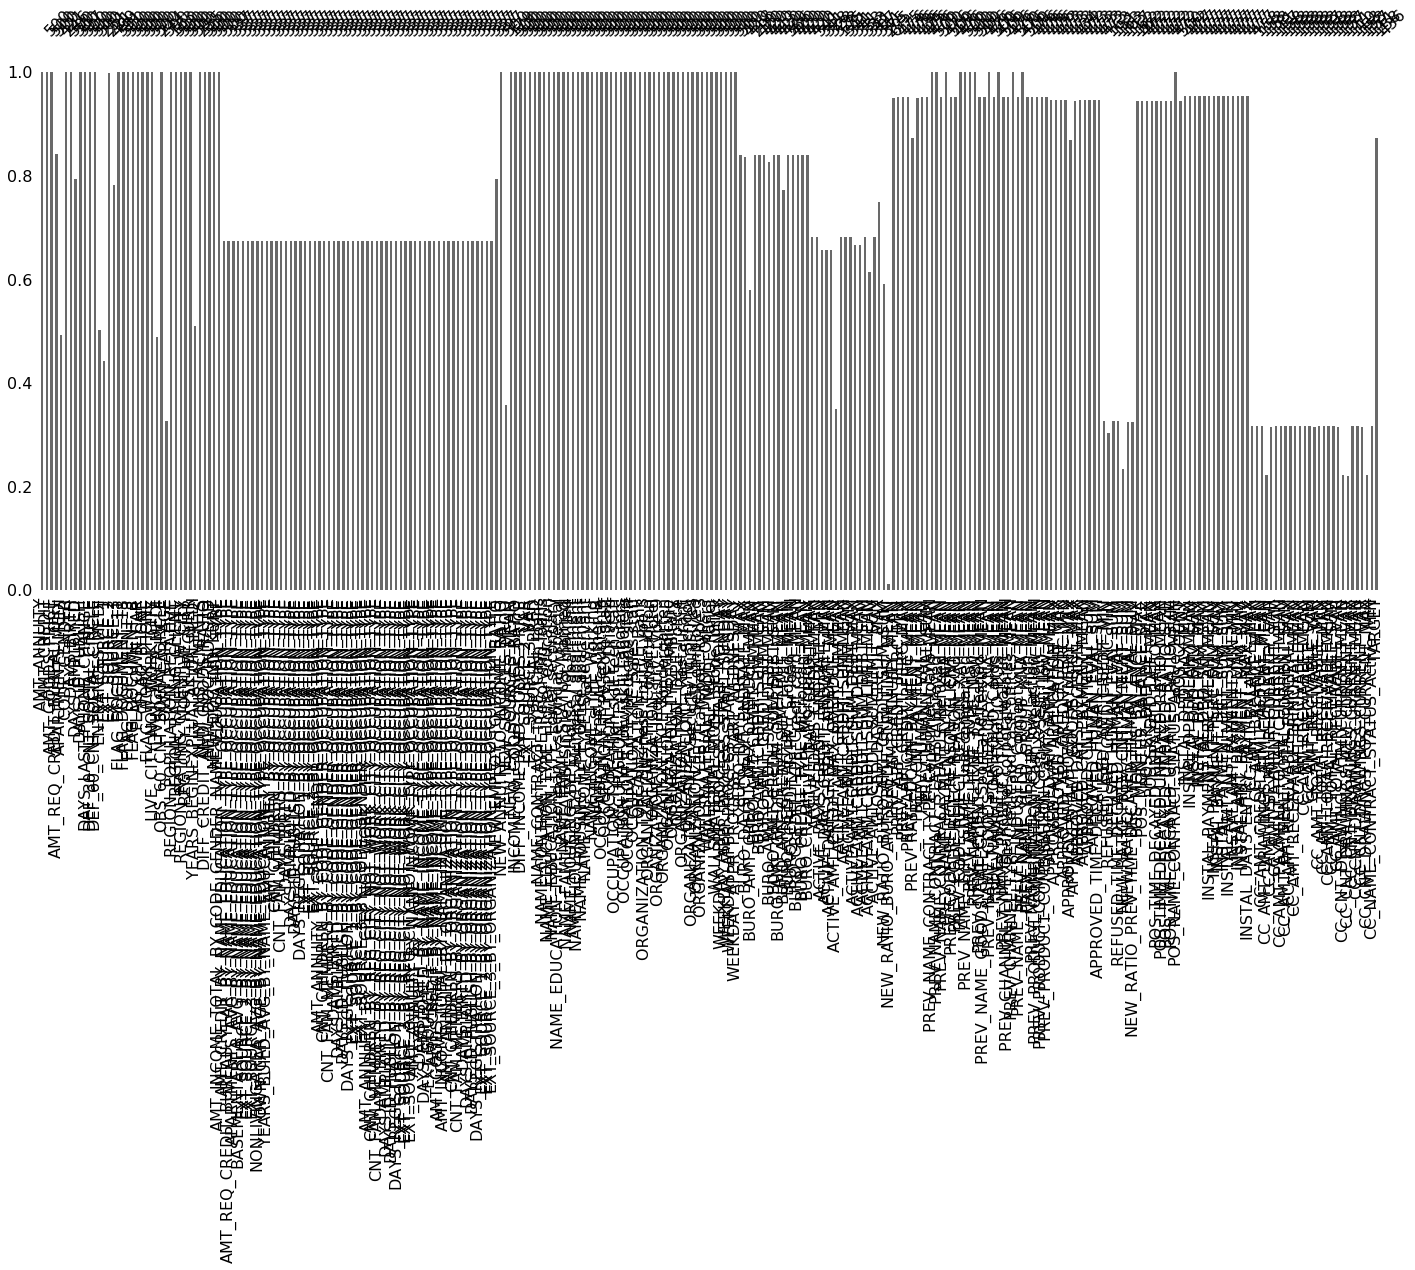

In [8]:
df = pd.read_hdf('../features/filled_by_mice/')

(356251, 281)


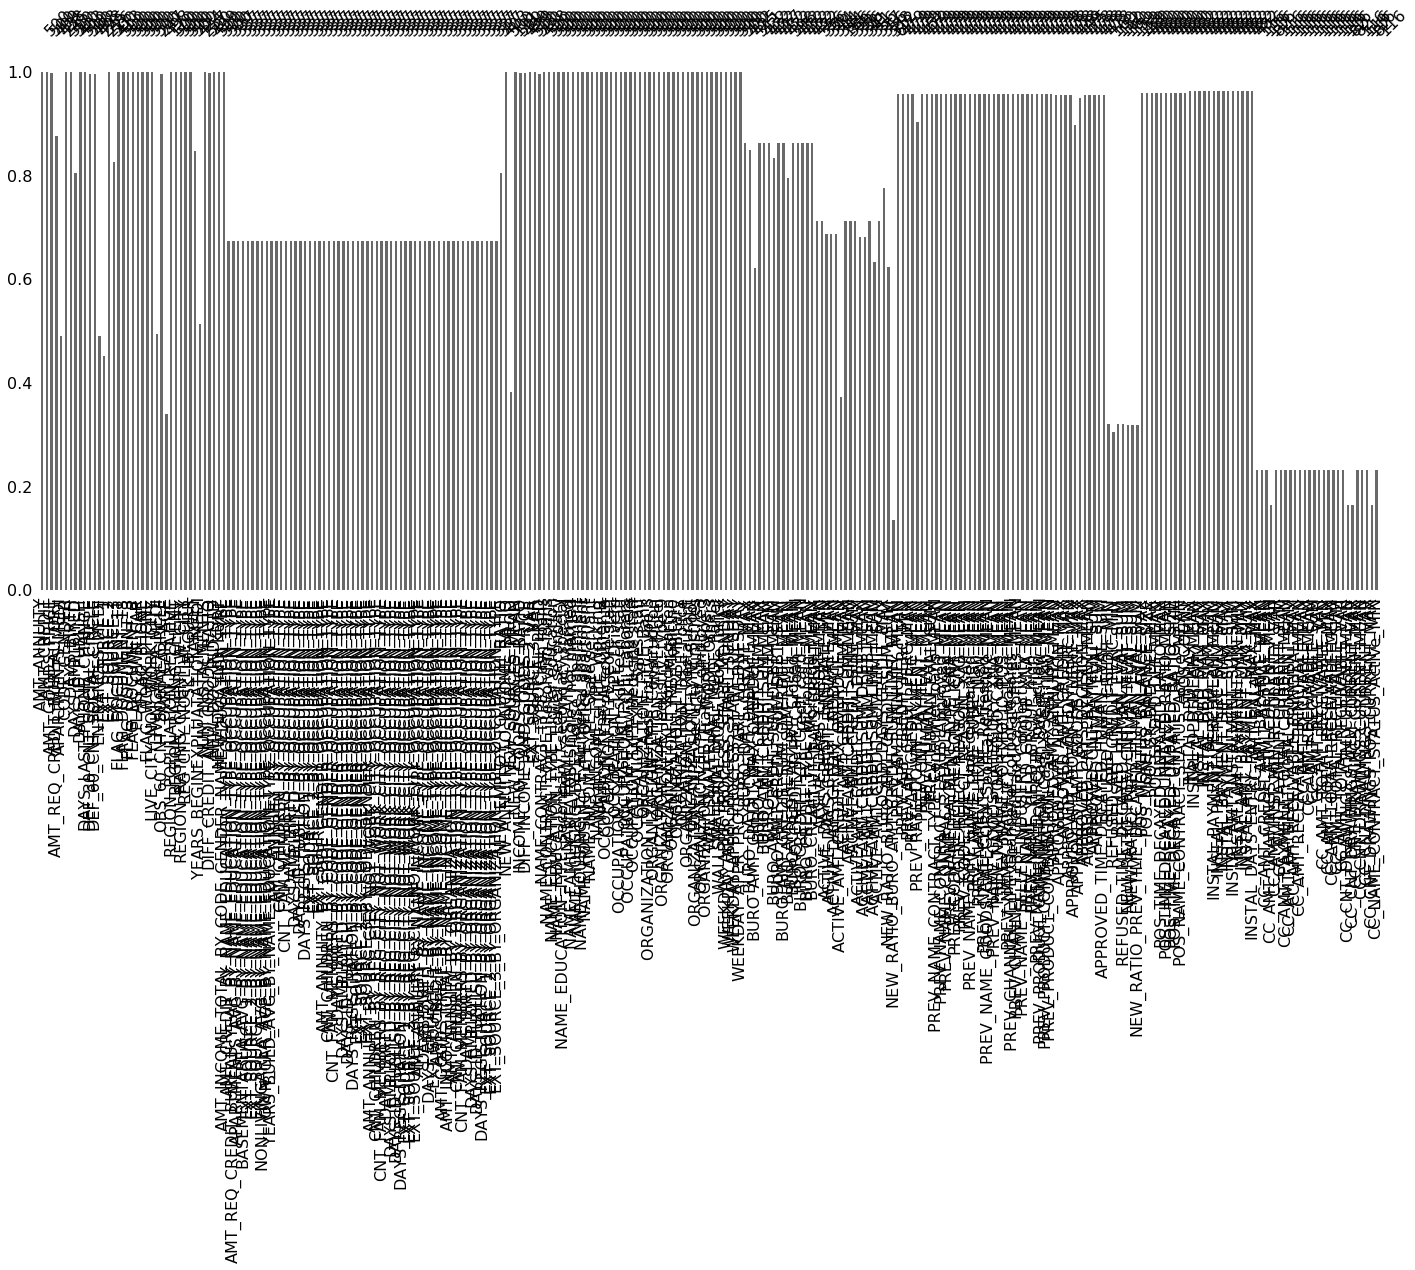

In [9]:
# reload again for filling
df = pd.read_hdf('../features/base_featurs.h5','base_featurs')
print (df.shape)
copy_for_the_following_merge = df[['SK_ID_CURR','TARGET']].copy()
no_need_to_inpute = ['index']
df.drop(no_need_to_inpute, axis = 1, inplace = True)
msno.bar(df.sample(500))

In [11]:
df['PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN'].count()

338853